# House Prices Copetitions
## Import packages and Load data

In [1]:
import numpy as np
import pandas as pd
import pylab 
from scipy import stats
from scipy.stats import skew,norm
from scipy.stats.stats import pearsonr
import seaborn as sns; sns.set(style="ticks", color_codes=True, font_scale=1.5)
from matplotlib import pyplot as plt
%matplotlib inline
import mpl_toolkits
from scipy.special import boxcox1p
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
#from sklearn.preprocessing import Imputer
from sklearn.linear_model import Lasso
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import ensemble
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.model_selection import cross_val_predict
from sklearn import metrics
from sklearn.metrics import mean_absolute_error

data = pd.read_csv('../house/train.csv')
data = data.drop(['Id'], axis=1)

test = pd.read_csv('../house/test.csv')
y = np.log1p(data.SalePrice)

C:\Users\marce\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
data['GrLivArea^3'] = data.GrLivArea**3

In [31]:
scale = RobustScaler()

In [32]:
gr = scale.fit_transform(data[['GrLivArea', 'GrLivArea^2', 'GrLivArea^3']])

In [33]:
a = pd.DataFrame(gr)

In [30]:
a.describe()

,0,1,2
count,1.460000e+03,1.460000e+03,1.460000e+03
mean,-1.446332e-16,1.162312e-16,6.033986e-17
std,1.000343e+00,1.000343e+00,1.000343e+00
min,-2.249120e+00,-1.192661e+00,-6.132454e-01
25%,-7.347485e-01,-6.284571e-01,-4.374088e-01
50%,-9.797004e-02,-2.080358e-01,-2.248605e-01
75%,4.974036e-01,2.831506e-01,8.468496e-02
max,7.855574e+00,1.417983e+01,2.187917e+01


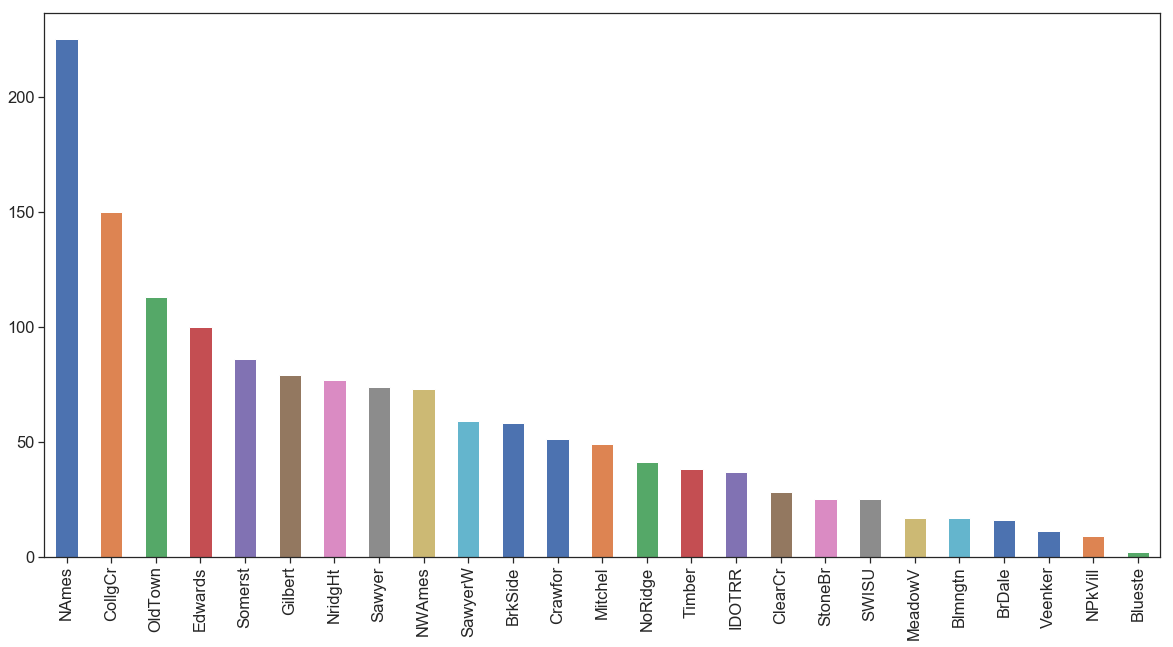

In [2]:
plt.figure(figsize=(20, 10))
data.Neighborhood.value_counts().plot(kind='bar')
plt.show()

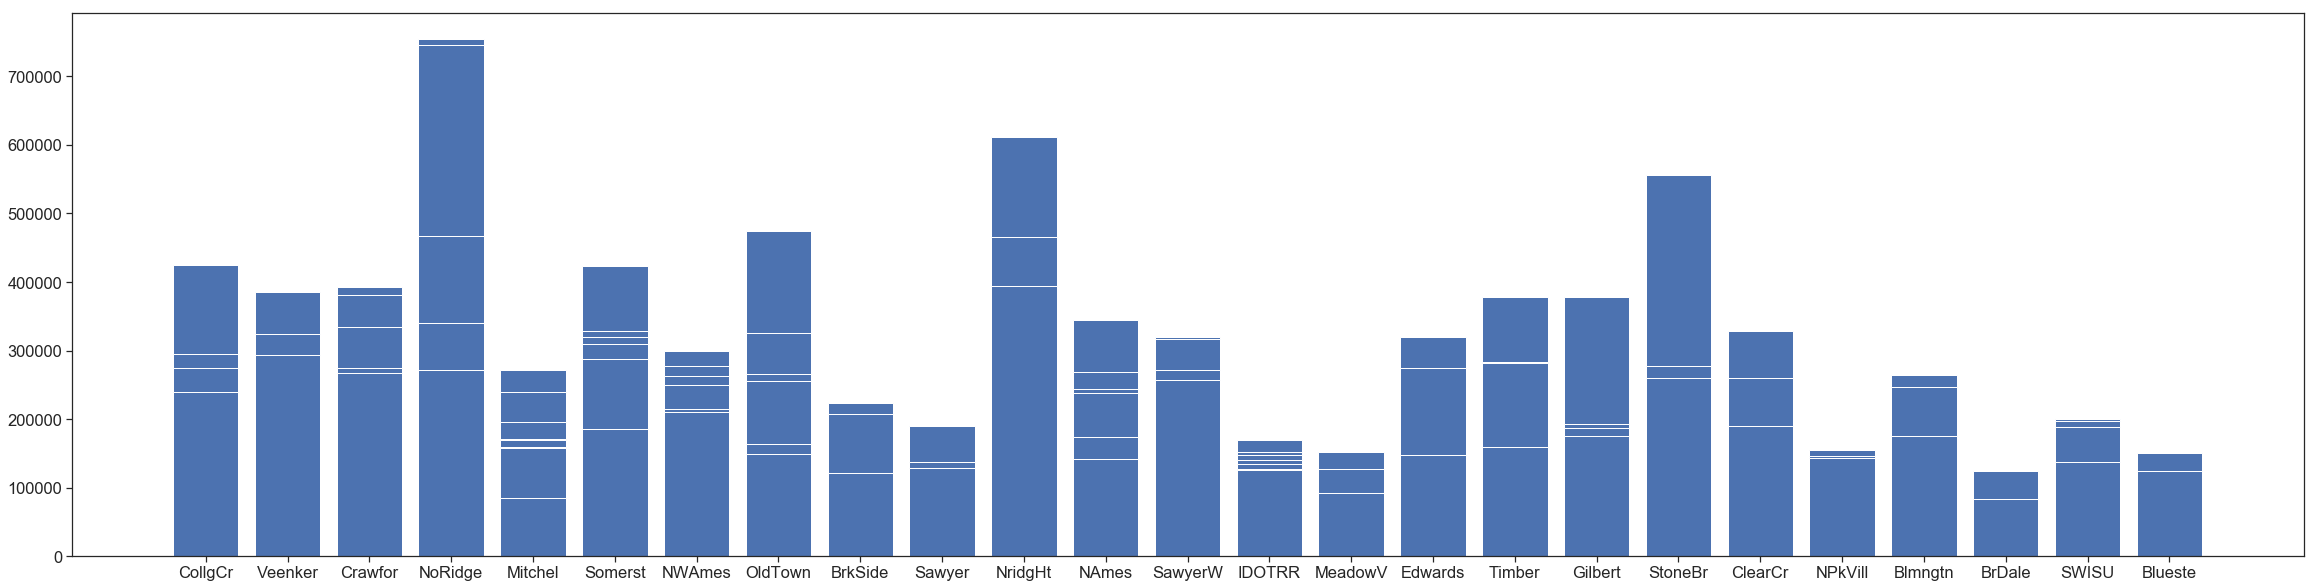

In [3]:
plt.figure(figsize=(40, 10))
plt.bar(data.Neighborhood, data.SalePrice)
plt.show()

C:\Users\marce\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


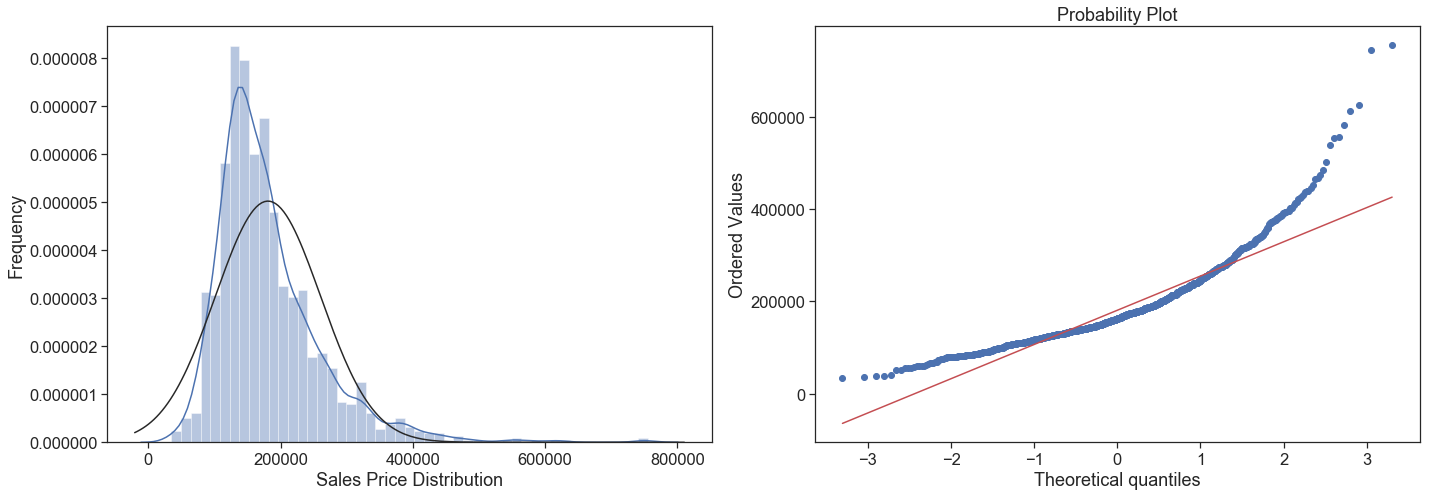

skewness: 1.882876
kurtosis: 6.536282


In [4]:
def kernel_QQ_plot(data, measure):
    fig = plt.figure(figsize=(20,7))

    #Kernel Density plot
    fig1 = fig.add_subplot(121)
    sns.distplot(data, fit=norm)
    fig1.set_xlabel(measure + ' Distribution')
    fig1.set_ylabel('Frequency')

    #Get the fitted parameters used by the function
    (mu, sigma) = norm.fit(data)

    #QQ plot
    fig2 = fig.add_subplot(122)
    res = stats.probplot(data, plot=fig2)

    plt.tight_layout()
    plt.show()

    print("skewness: %f" % data.skew())
    print("kurtosis: %f" % data.kurt())

kernel_QQ_plot(data.SalePrice, 'Sales Price')

C:\Users\marce\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


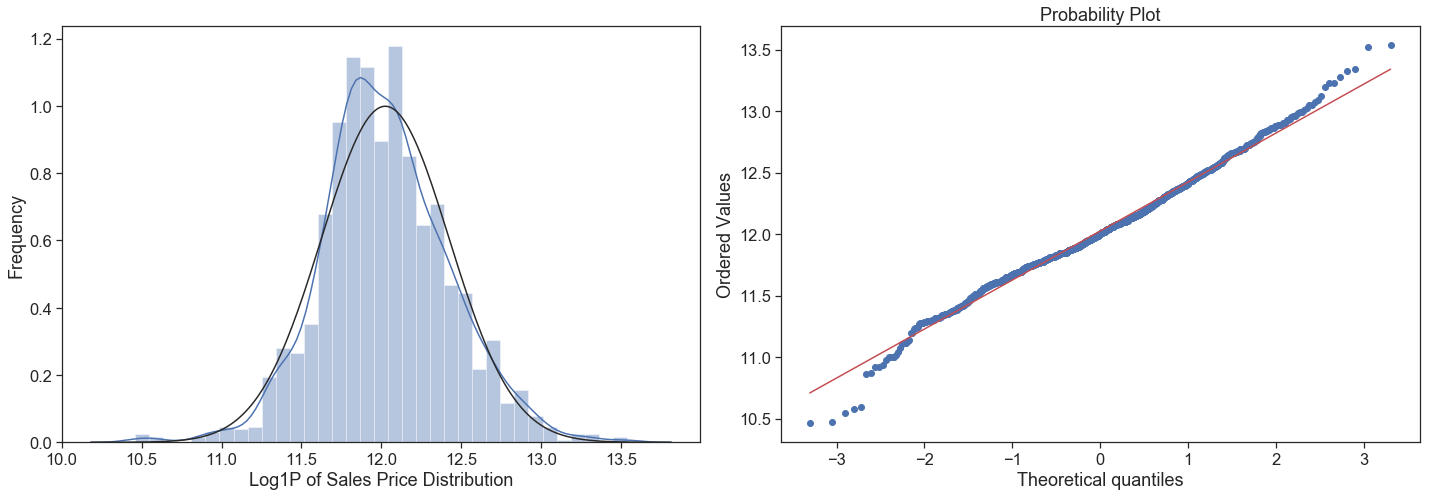

skewness: 0.121347
kurtosis: 0.809519


In [5]:
kernel_QQ_plot(y, 'Log1P of Sales Price')

In [6]:
def rstr(df, pred=None): 
    obs = df.shape[0]
    types = df.dtypes
    counts = df.apply(lambda x: x.count())
    uniques = df.apply(lambda x: [x.unique()])
    nulls = df.apply(lambda x: x.isnull().sum())
    distincts = df.apply(lambda x: x.unique().shape[0])
    missing_ration = (df.isnull().sum()/ obs) * 100

    
    if pred is None:
        cols = ['types', 'counts', 'distincts', 'nulls', 'missing ration', 'uniques']
        str = pd.concat([types, counts, distincts, nulls, missing_ration, uniques], axis = 1)

    else:
        corr = df.corr()[pred]
        str = pd.concat([types, counts, distincts, nulls, missing_ration, uniques, corr], axis = 1, sort=False)
        corr_col = 'corr '  + pred
        cols = ['types', 'counts', 'distincts', 'nulls', 'missing_ration', 'uniques', corr_col ]
    
    str.columns = cols

    return str
details = rstr(data, 'SalePrice')
details.sort_values(by='nulls', ascending=False)

,types,counts,distincts,nulls,missing_ration,uniques,corr SalePrice
PoolQC,object,7,4,1453,99.520548,"[[nan, Ex, Fa, Gd]]",NaN
MiscFeature,object,54,5,1406,96.301370,"[[nan, Shed, Gar2, Othr, TenC]]",NaN
Alley,object,91,3,1369,93.767123,"[[nan, Grvl, Pave]]",NaN
Fence,object,281,5,1179,80.753425,"[[nan, MnPrv, GdWo, GdPrv, MnWw]]",NaN
FireplaceQu,object,770,6,690,47.260274,"[[nan, TA, Gd, Fa, Ex, Po]]",NaN
LotFrontage,float64,1201,111,259,17.739726,"[[65.0, 80.0, 68.0, 60.0, 84.0, 85.0, 75.0, na...",0.351799
GarageYrBlt,float64,1379,98,81,5.547945,"[[2003.0, 1976.0, 2001.0, 1998.0, 2000.0, 1993...",0.486362
GarageCond,object,1379,6,81,5.547945,"[[TA, Fa, nan, Gd, Po, Ex]]",NaN
GarageType,object,1379,7,81,5.547945,"[[Attchd, Detchd, BuiltIn, CarPort, nan, Basme...",NaN
GarageFinish,object,1379,4,81,5.547945,"[[RFn, Unf, Fin, nan]]",NaN


### Check for any correlations between variables

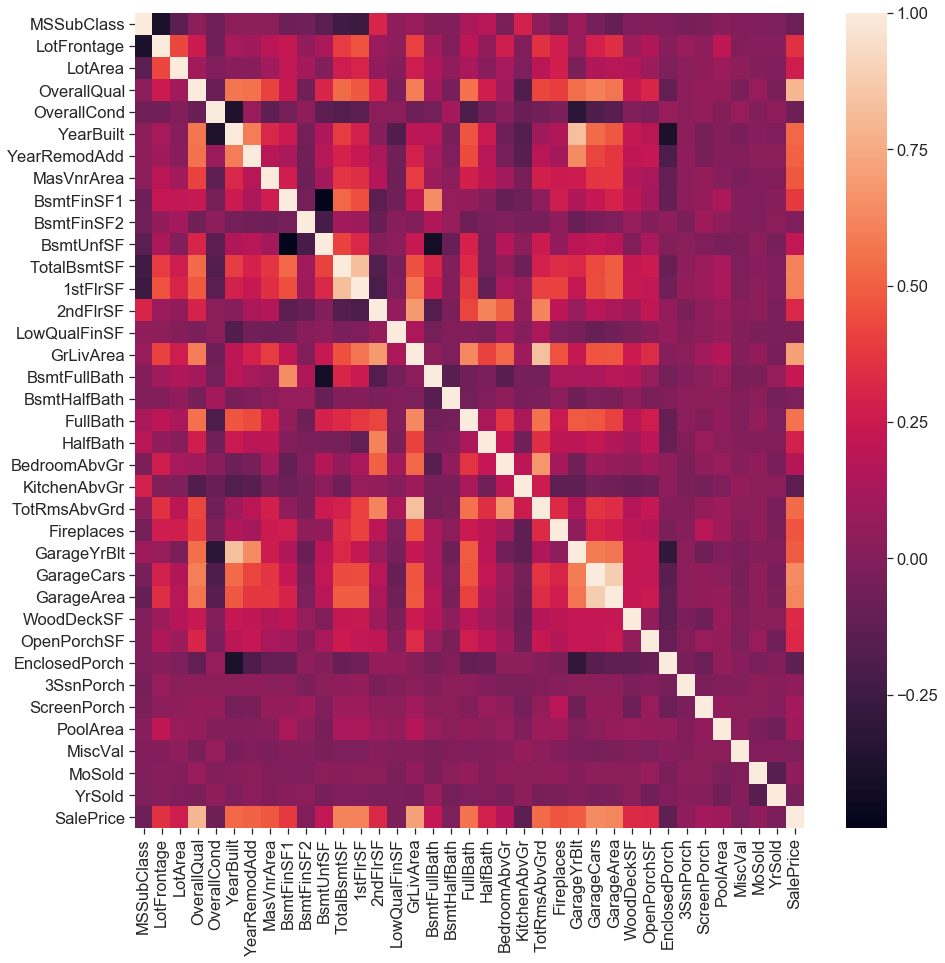

In [7]:
plt.figure(figsize=(15, 15))
sns.heatmap(data.corr())
sns.set(font_scale=1.5)
plt.show()

In [8]:
corr_SalePrice = data.corr().SalePrice
corr_SalePrice.sort_values(ascending=False)

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64

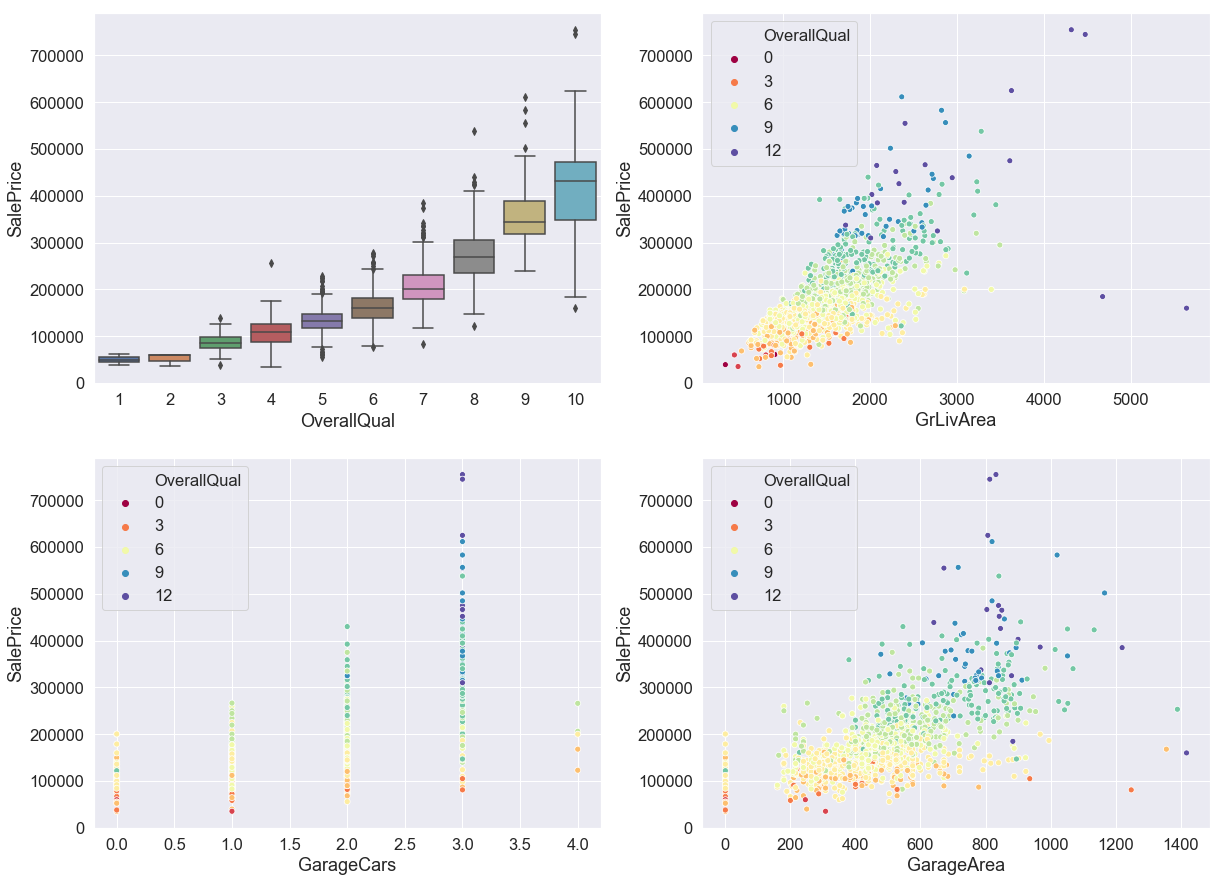

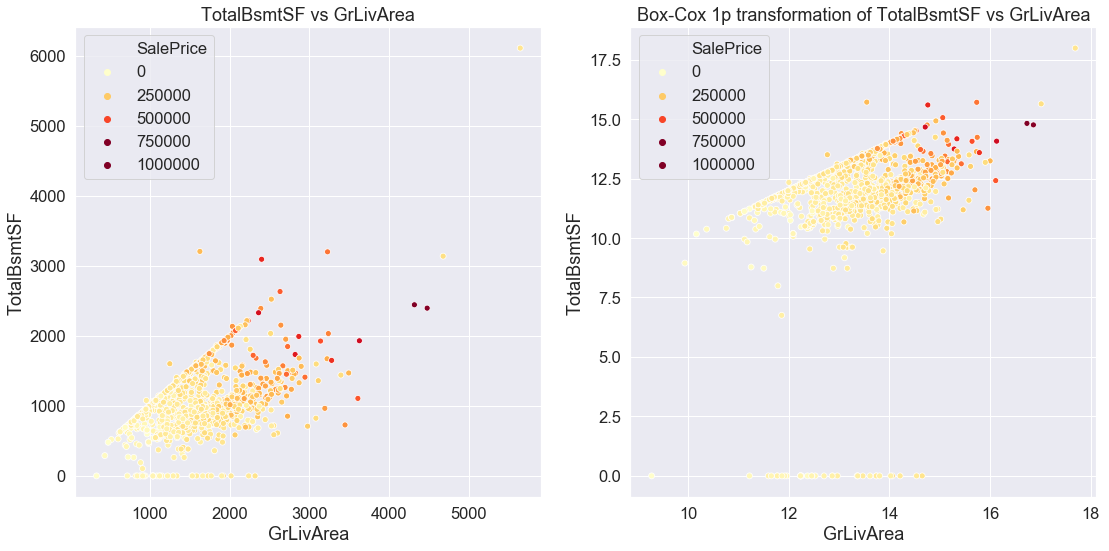

In [9]:
fig = plt.figure(figsize=(20, 15))
sns.set(font_scale=1.5)

# (Corr= 0.817185) Box plot overallqual/salePrice
fig1 = fig.add_subplot(221)
a = sns.boxplot(x='OverallQual', y='SalePrice', data=data[['SalePrice', 'OverallQual']])

# (Corr= 0.700927) GrLivArea vs SalePrice plot
fig2 = fig.add_subplot(222)
sns.scatterplot(x = data.GrLivArea, y = data.SalePrice, hue=data.OverallQual, palette= 'Spectral')

# (Corr= 0.680625) GarageCars vs SalePrice plot
fig3 = fig.add_subplot(223)
sns.scatterplot(x = data.GarageCars, y = data.SalePrice, hue=data.OverallQual, palette= 'Spectral')

# (Corr= 0.650888) GarageArea vs SalePrice plot
fig4 = fig.add_subplot(224)
sns.scatterplot(x = data.GarageArea, y = data.SalePrice, hue=data.OverallQual, palette= 'Spectral')


fig5 = plt.figure(figsize=(16, 8))

fig1 = fig5.add_subplot(121)
sns.scatterplot(y = data.TotalBsmtSF , x = data.GrLivArea, hue=data.SalePrice, palette= 'YlOrRd')
fig1.set_title('TotalBsmtSF vs GrLivArea')

fig2 = fig5.add_subplot(122)
sns.scatterplot(y = boxcox1p(data.TotalBsmtSF, 0.15), 
                x = boxcox1p( data.GrLivArea , 0.15),
                hue=data.SalePrice, palette= 'YlOrRd')
fig2.set_title('Box-Cox 1p transformation of TotalBsmtSF vs GrLivArea')
plt.tight_layout()
plt.show()

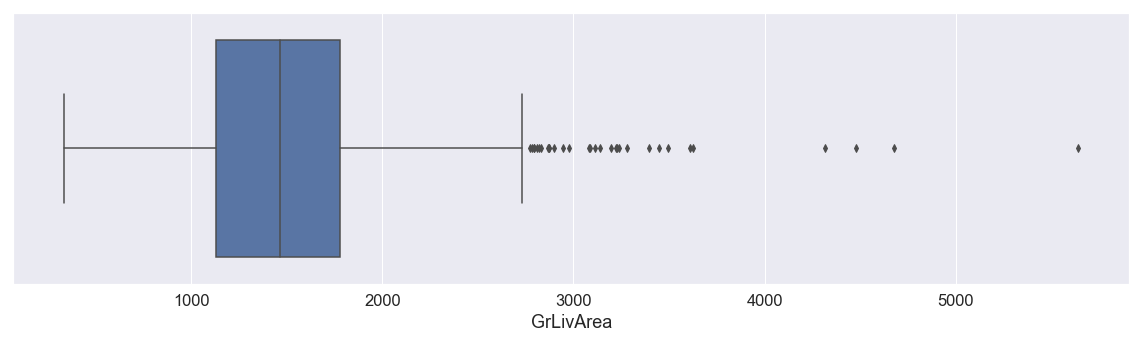

In [10]:
plt.figure(figsize=(20,5))
sns.boxplot(data.GrLivArea)

In [11]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MSSubClass,1460.0,56.897260,42.300571,20.0,20.00,50.0,70.00,190.0
LotFrontage,1201.0,70.049958,24.284752,21.0,59.00,69.0,80.00,313.0
LotArea,1460.0,10516.828082,9981.264932,1300.0,7553.50,9478.5,11601.50,215245.0
OverallQual,1460.0,6.099315,1.382997,1.0,5.00,6.0,7.00,10.0
OverallCond,1460.0,5.575342,1.112799,1.0,5.00,5.0,6.00,9.0
YearBuilt,1460.0,1971.267808,30.202904,1872.0,1954.00,1973.0,2000.00,2010.0
YearRemodAdd,1460.0,1984.865753,20.645407,1950.0,1967.00,1994.0,2004.00,2010.0
MasVnrArea,1452.0,103.685262,181.066207,0.0,0.00,0.0,166.00,1600.0
BsmtFinSF1,1460.0,443.639726,456.098091,0.0,0.00,383.5,712.25,5644.0
BsmtFinSF2,1460.0,46.549315,161.319273,0.0,0.00,0.0,0.00,1474.0


# Check Data Quality:
## Nulls Check:

In [12]:
all_data = pd.concat((data.loc[:, 'MSSubClass': 'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))

print("All data observations have {0} rows and {1} columns".format(all_data.shape[0], all_data.shape[1]))
details = rstr(all_data)
print("All data have {1:2.2%} of null at {0} features".format(details[details.nulls>0].shape[0], 
                                                   details.nulls[details.nulls>0].sum()/all_data.size))
details[details.nulls>0].sort_values(by= 'missing ration', ascending=False)

All data observations have 2919 rows and 79 columns
All data have 6.06% of null at 34 features


,types,counts,distincts,nulls,missing ration,uniques
PoolQC,object,10,4,2909,99.657417,"[[nan, Ex, Fa, Gd]]"
MiscFeature,object,105,5,2814,96.402878,"[[nan, Shed, Gar2, Othr, TenC]]"
Alley,object,198,3,2721,93.216855,"[[nan, Grvl, Pave]]"
Fence,object,571,5,2348,80.438506,"[[nan, MnPrv, GdWo, GdPrv, MnWw]]"
FireplaceQu,object,1499,6,1420,48.646797,"[[nan, TA, Gd, Fa, Ex, Po]]"
LotFrontage,float64,2433,129,486,16.649538,"[[65.0, 80.0, 68.0, 60.0, 84.0, 85.0, 75.0, na..."
GarageFinish,object,2760,4,159,5.447071,"[[RFn, Unf, Fin, nan]]"
GarageQual,object,2760,6,159,5.447071,"[[TA, Fa, Gd, nan, Ex, Po]]"
GarageCond,object,2760,6,159,5.447071,"[[TA, Fa, nan, Gd, Po, Ex]]"
GarageYrBlt,float64,2760,104,159,5.447071,"[[2003.0, 1976.0, 2001.0, 1998.0, 2000.0, 1993..."


In [13]:
class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value 
        in column.

        Columns of other types are imputed with mean of column.

        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)

## Some Observations Respect Data Quality:
<p>The total training observations are 1,460 and have 79 features ( 3 float64, 33 int64, 43 object ) with 19 columns with nulls
All data observations, including test dataste, have 2919 rows and 79 features, where 6.06% are nulls, but found nulls at 34 diferente features. So the test dataset has null in features that training dataset doesn't have!

***Based on feature description provide, A feature that has NA means it is absent***
<p>
First, before we assume this as a total reality, we need check some quality issues, like the record has Garage, but doesn't have Garage Quality and vice versa.


 - 14 has few null, so are good candidates for imputer strategies:
   - GarageFinish  1379  object.  Interior finish of the garage.
   - GarageQual    1379  object:  Garage quality. 
   - GarageCond    1379  object:  Garage condition. 
   - GarageType    1379  object:  Garage location
   - GarageYrBlt   1379  float64: Year garage was built
   - Electrical    1459  object.  Only one, can apply the most commun.
   - MasVnrType    1452  object:  is the masonry veneer type, hasn't CBlock!
   - MasVnrArea    1452  float64: Masonry veneer area in square feet.   
   - BsmtExposure  1422  object:  Refers to walkout or garden level walls.
   - BsmtFinType2  1422  object:  Rating of basement finished area (if multiple types).
   - BsmtQual      1423  object:  Evaluates the height of the basement Doesn't have PO.
   - BsmtCond      1423  object:  Ealuates the general condition of the basement. 
   - BsmtFinType1  1423  object:  Rating of basement finished area (if multiple types).    
   - LotFrontage   1201  float64: is the linear feet of street connected to property.
<p>
 - 5 has miss ration grater than 47%, maybe candidates to exclude, especially if their have below correlation with price.
    - Fence         281  object: Fence quality.
    - FireplaceQu   770  object: Fireplace quality.
    - MiscFeature    54  object: Miscellaneous feature not covered in other categories. 
    - Alley          91  object: is the type of alley access to property.
    - PoolQC          7  object: Pool quality. Atention for the related other feature PoolArea: Pool area in square feet

Some numeric data are ordinal or categorical already translate to codes. We need correct identify the ordinal from the description and can maintain as is, but need to change de categoricals.<p>
    
### Identify the Most Commun Electrical:

In [14]:
all_data.Electrical.value_counts()

SBrkr    2671
FuseA     188
FuseF      50
FuseP       8
Mix         1
Name: Electrical, dtype: int64

In [15]:
all_data.Electrical = all_data.Electrical.fillna('SBrkr')

### Fill Missing Values of Garage Features:
Identify if has some special cases where we find some garage feature inputted, where's others garages features are null.

In [16]:
feat = ['GarageYrBlt', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'GarageArea', 'GarageCars']
print(all_data[feat].isnull().sum())
print("GarageArea equal a 0: ", (all_data.GarageArea==0).sum())
print("GarageCars equal a 0: ", (all_data.GarageCars==0).sum())
c = all_data[~all_data.GarageType.isnull()][feat]
c[c.GarageYrBlt.isnull()]

GarageYrBlt     159
GarageType      157
GarageFinish    159
GarageQual      159
GarageCond      159
GarageArea        1
GarageCars        1
dtype: int64
GarageArea equal a 0:  157
GarageCars equal a 0:  157


,GarageYrBlt,GarageType,GarageFinish,GarageQual,GarageCond,GarageArea,GarageCars
666,NaN,Detchd,NaN,NaN,NaN,360.0,1.0
1116,NaN,Detchd,NaN,NaN,NaN,NaN,NaN


#### Group by GarageType and fill missing value with median or mode where GarageType equal a Detchd and 0 or NA for the others

In [17]:
all_data.GarageType = all_data.GarageType.fillna('NA')

# Group by GarageType and fill missing value with median where GarageType=='Detchd' and 0 for the others
cmedian = all_data[all_data.GarageType=='Detchd'].GarageArea.median()
print("GarageArea median of Type Detchd:", cmedian)
all_data.loc[all_data.GarageType=='Detchd', 'GarageArea'] = all_data.loc[all_data.GarageType=='Detchd', 
                                                                         'GarageArea'].fillna(cmedian)
all_data.GarageArea = all_data.GarageArea.fillna(0)

cmedian = all_data[all_data.GarageType=='Detchd'].GarageCars.median()
print("GarageCars median of Type Detchd:", cmedian)
all_data.loc[all_data.GarageType=='Detchd', 'GarageCars'] = all_data.loc[all_data.GarageType=='Detchd', 
                                                                         'GarageCars'].fillna(cmedian)
all_data.GarageCars = all_data.GarageCars.fillna(0)

cmedian = all_data[all_data.GarageType=='Detchd'].GarageYrBlt.median()
print("GarageYrBlt median of Type Detchd:", cmedian)
all_data.loc[all_data.GarageType=='Detchd', 'GarageYrBlt'] = all_data.loc[all_data.GarageType=='Detchd', 
                                                                          'GarageYrBlt'].fillna(cmedian)
all_data.GarageYrBlt = all_data.GarageYrBlt.fillna(0)

# Group by GarageType and fill missing value with mode where GarageType=='Detchd' and 'NA' for the others
cmode = all_data[all_data.GarageType=='Detchd'].GarageFinish.mode()[0]
print("GarageFinish mode of Type Detchd:", cmode)
all_data.loc[all_data.GarageType=='Detchd', 'GarageFinish'] = all_data.loc[all_data.GarageType=='Detchd', 
                                                                           'GarageFinish'].fillna(cmode)
all_data.GarageFinish = all_data.GarageFinish.fillna('NA')

cmode = all_data[all_data.GarageType=='Detchd'].GarageQual.mode()[0]
print("GarageQual mode of Type Detchd: %s" %cmode)
all_data.loc[all_data.GarageType=='Detchd', 'GarageQual'] = all_data.loc[all_data.GarageType=='Detchd', 
                                                                         'GarageQual'].fillna(cmode)
all_data.GarageQual = all_data.GarageQual.fillna('NA')

cmode = all_data[all_data.GarageType=='Detchd'].GarageCond.mode()[0]
print("GarageCond mode of Type Detchd:", cmode)
all_data.loc[all_data.GarageType=='Detchd', 'GarageCond'] = all_data.loc[all_data.GarageType=='Detchd', 
                                                                         'GarageCond'].fillna(cmode)
all_data.GarageCond = all_data.GarageCond.fillna('NA')

GarageArea median of Type Detchd: 399.5
GarageCars median of Type Detchd: 2.0
GarageYrBlt median of Type Detchd: 1962.0
GarageFinish mode of Type Detchd: Unf
GarageQual mode of Type Detchd: TA
GarageCond mode of Type Detchd: TA


### Check if all nulls of Garage features are inputed

In [18]:
print(all_data[feat].isnull().sum())

GarageYrBlt     0
GarageType      0
GarageFinish    0
GarageQual      0
GarageCond      0
GarageArea      0
GarageCars      0
dtype: int64


### Masonry veneer - Check Nulls and Data Quality Problems:

In [19]:
feat = ['MasVnrArea', 'MasVnrType']
c = all_data[~all_data.MasVnrArea.isnull()][feat]
print('Masonry veneer Nulls:')
print(all_data[feat].isnull().sum(), '\n')
print("Has MasVnrType but not has MasVnrArea:",all_data[~all_data.MasVnrType.isnull()].MasVnrArea.isnull().sum())
print("Has MasVnrArea but not has MasVnrType:",c[c.MasVnrType.isnull()].MasVnrArea.count())
print(c[c.MasVnrType.isnull()], '\n')

print("Has MasVnrType but MasVnrArea is equal a Zero:",c[c.MasVnrArea==0].MasVnrType.count())
print("MasVnrArea equal a 0: ", (all_data.MasVnrArea==0).sum(), '\n')
print("Has Type and Area == 0:")
print(c[c.MasVnrArea==0].MasVnrType.value_counts(), '\n')

print("Type None with Area > 0 ?")
print(all_data.loc[(all_data.MasVnrType=='None') & (all_data.MasVnrArea>0), ['MasVnrType','MasVnrArea']])

print('\n What is the most comumn MasVnrType after None?')
print(all_data.MasVnrType.value_counts())

Masonry veneer Nulls:
MasVnrArea    23
MasVnrType    24
dtype: int64 

Has MasVnrType but not has MasVnrArea: 0
Has MasVnrArea but not has MasVnrType: 1
      MasVnrArea MasVnrType
1150       198.0        NaN 

Has MasVnrType but MasVnrArea is equal a Zero: 1738
MasVnrArea equal a 0:  1738 

Has Type and Area == 0:
None       1735
BrkFace       2
Stone         1
Name: MasVnrType, dtype: int64 

Type None with Area > 0 ?
     MasVnrType  MasVnrArea
624        None       288.0
773        None         1.0
1230       None         1.0
1300       None       344.0
1334       None       312.0
209        None       285.0
992        None         1.0

 What is the most comumn MasVnrType after None?
None       1742
BrkFace     879
Stone       249
BrkCmn       25
Name: MasVnrType, dtype: int64


### Masonry veneer - Input nulls and Solve Data Quality Problames:

In [20]:
all_data.MasVnrType.value_counts()

None       1742
BrkFace     879
Stone       249
BrkCmn       25
Name: MasVnrType, dtype: int64

#### Corret to BrkFace the Massory Veneer Types Nulls and Nones wheres records has Massory Veneer Area

In [21]:
# All None Types with Are greater than 0 update to BrkFace type
all_data.loc[(all_data.MasVnrType=='None') & (all_data.MasVnrArea>0), ['MasVnrType']] = 'BrkFace'

# All Types null with Are greater than 0 update to BrkFace type
all_data.loc[(all_data.MasVnrType.isnull()) & (all_data.MasVnrArea>0), ['MasVnrType']] = 'BrkFace'

# All Types different from None with Are equal to 0 update to median Area of no None types with Areas
all_data.loc[(all_data.MasVnrType!='None') & 
             (all_data.MasVnrArea==0), ['MasVnrArea']] = all_data.loc[(all_data.MasVnrType!='None') & 
                                                                      (all_data.MasVnrArea>0), ['MasVnrArea']].median()[0]
# Filling 0 and None for records wheres both are nulls
all_data.MasVnrArea = all_data.MasVnrArea.fillna(0)
all_data.MasVnrType = all_data.MasVnrType.fillna('None')

#### Check if all Null are updeted

In [22]:
c = all_data[~all_data.MasVnrType.isnull()][feat]
print('Masonry veneer Nulls:')
print(all_data[feat].isnull().sum(), '\n')

Masonry veneer Nulls:
MasVnrArea    0
MasVnrType    0
dtype: int64 



### Check and Input Basement Features Nulls:

In [23]:
feat = ['BsmtFinSF1','BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF','BsmtFullBath', 'BsmtHalfBath', 
        'BsmtQual', 'BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2']
print(all_data[feat].isnull().sum())
print("BsmtFinSF1 equal a 0: ", (all_data.BsmtFinSF1==0).sum())
print("BsmtFinSF2 equal a 0: ", (all_data.BsmtFinSF2==0).sum())
print("BsmtUnfSF equal a 0: ", (all_data.BsmtUnfSF==0).sum())
print("TotalBsmtSF equal a 0: ", (all_data.TotalBsmtSF==0).sum())
print("BsmtFullBath equal a 0: ", (all_data.BsmtFullBath==0).sum())
print("BsmtHalfBath equal a 0: ", (all_data.BsmtHalfBath==0).sum())
#c = all_data[~all_data.GarageType.isnull()][feat]
#c[c.GarageYrBlt.isnull()]

BsmtFinSF1       1
BsmtFinSF2       1
BsmtUnfSF        1
TotalBsmtSF      1
BsmtFullBath     2
BsmtHalfBath     2
BsmtQual        81
BsmtCond        82
BsmtExposure    82
BsmtFinType1    79
BsmtFinType2    80
dtype: int64
BsmtFinSF1 equal a 0:  929
BsmtFinSF2 equal a 0:  2571
BsmtUnfSF equal a 0:  241
TotalBsmtSF equal a 0:  78
BsmtFullBath equal a 0:  1705
BsmtHalfBath equal a 0:  2742


In [24]:
# After No Basement Av is the most comumn BsmtExposure. 
all_data.BsmtExposure.value_counts()

No    1904
Av     418
Gd     276
Mn     239
Name: BsmtExposure, dtype: int64

In [25]:
# Update nulls Exposure to Av wheres TotalBsmntSF is grenter tham zero 
all_data.loc[(~all_data.TotalBsmtSF.isnull()) & 
             (all_data.BsmtExposure.isnull()) & 
             (all_data.TotalBsmtSF>0), 'BsmtExposure'] = 'Av'

In [26]:
# TA is the most comumn BsmtQual. 
all_data.BsmtQual.value_counts()

TA    1283
Gd    1209
Ex     258
Fa      88
Name: BsmtQual, dtype: int64

In [27]:
# We use TA for all cases wheres has same evidenci that the house has Basement
all_data.loc[(~all_data.TotalBsmtSF.isnull()) & 
             (all_data.BsmtQual.isnull()) & 
             (all_data.TotalBsmtSF>0), 'BsmtQual'] = 'TA'

In [28]:
# TA is the most comumn BsmtCond. 
all_data.BsmtCond.value_counts()

TA    2606
Gd     122
Fa     104
Po       5
Name: BsmtCond, dtype: int64

In [29]:
# We use TA for all cases wheres has same evidenci that the house has Basement
all_data.loc[(~all_data.TotalBsmtSF.isnull()) & (all_data.BsmtCond.isnull()) & (all_data.TotalBsmtSF>0), 'BsmtCond'] = 'TA'

In [30]:
# Unf is the most comumn BsmtFinType2. 
all_data.BsmtFinType2.value_counts()

Unf    2493
Rec     105
LwQ      87
BLQ      68
ALQ      52
GLQ      34
Name: BsmtFinType2, dtype: int64

In [31]:
# We use Unf for all cases wheres BsmtFinType2 is null but BsmtFinSF2 is grater than Zro
all_data.loc[(all_data.BsmtFinSF2>0) & (all_data.BsmtFinType2.isnull()) , 'BsmtFinType2'] = 'Unf'

In [32]:
# See below that we have one case where BsmtFinType2 is BLQ and the Area is Zero, but its area was inputed at Unfinesh
all_data[(all_data.BsmtFinSF2==0) & (all_data.BsmtFinType2!='Unf') & (~all_data.BsmtFinType2.isnull())][feat]

,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2
10,1051.0,0.0,354.0,1405.0,1.0,0.0,Gd,TA,No,GLQ,BLQ


In [33]:
# Correct BsmtFinSF2 and BsmtUnfSF:
all_data.loc[(all_data.BsmtFinSF2==0) & (all_data.BsmtFinType2!='Unf') & (~all_data.BsmtFinType2.isnull()), 'BsmtFinSF2'] = 354.0
all_data.loc[(all_data.BsmtFinSF2==0) & (all_data.BsmtFinType2!='Unf') & (~all_data.BsmtFinType2.isnull()), 'BsmtUnfSF'] = 0.0

In [34]:
# All these cases are clear don´t have basement. 
print("Rest cases where Cond is Null", (all_data[all_data.BsmtCond.isnull()]).shape[0], '\n')
print('Others categories basement features are Null when Cond is Null:\n',
      (all_data[all_data.BsmtCond.isnull()][['BsmtQual', 'BsmtCond', 'BsmtExposure',
                                             'BsmtFinType1' , 'BsmtFinType2']]).isnull().sum())
print('\nOthers numerics basement features are Null or Zero when Cond is Null:\n',
      all_data[all_data.BsmtCond.isnull()][['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF' ,'TotalBsmtSF',
                                            'BsmtFullBath', 'BsmtHalfBath']].sum())
print("\nThe particular cases where's numeric basement features see below are Null were included in the previous groups:", 
      all_data[all_data.BsmtFullBath.isnull()][feat])

# So, we update these Zero or NA according to their dictionary:
nulls_cols = {'BsmtExposure': 'NA', 'BsmtFinType2': 'NA', 'BsmtQual': 'NA', 'BsmtCond': 'NA', 'BsmtFinType1': 'NA',
              'BsmtFinSF1': 0, 'BsmtFinSF2': 0, 'BsmtUnfSF': 0 ,'TotalBsmtSF': 0, 'BsmtFullBath': 0, 'BsmtHalfBath': 0}

all_data = all_data.fillna(value=nulls_cols)

print('\nFinal Check if all nulls basement features are treated:', all_data[feat].isnull().sum().sum())

Rest cases where Cond is Null 79 

Others categories basement features are Null when Cond is Null:
 BsmtQual        79
BsmtCond        79
BsmtExposure    79
BsmtFinType1    79
BsmtFinType2    79
dtype: int64

Others numerics basement features are Null or Zero when Cond is Null:
 BsmtFinSF1      0.0
BsmtFinSF2      0.0
BsmtUnfSF       0.0
TotalBsmtSF     0.0
BsmtFullBath    0.0
BsmtHalfBath    0.0
dtype: float64

The particular cases where's numeric basement features see below are Null were included in the previous groups:      BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  BsmtFullBath  \
660         NaN         NaN        NaN          NaN           NaN   
728         0.0         0.0        0.0          0.0           NaN   

     BsmtHalfBath BsmtQual BsmtCond BsmtExposure BsmtFinType1 BsmtFinType2  
660           NaN      NaN      NaN          NaN          NaN          NaN  
728           NaN      NaN      NaN          NaN          NaN          NaN  

Final Check if all nulls basemen

### LotFrontage - Check and Fill Nulls

In [35]:
# Group by Neigborhood and fill missing value with Lot frontage median of the respect Neigborhood
NegMean = all_data.groupby('Neighborhood').LotFrontage.mean()

all_data.loc[all_data.LotFrontage.isnull() , 'LotFrontage'] = all_data.loc[all_data.LotFrontage.isnull() , 
                                                                            'Neighborhood'].apply(lambda x: NegMean[x])

### PoolQC - Fill Nulls

In [36]:
# Probably models won't use Pools Features, since they has few correlation to price (0.069798) and more than 99% of missing
# But for the moment, we still filling null of PoolQC that has Area with Gd.
print('Modes of Pool Quality:\n', all_data.PoolQC.mode())
all_data.loc[(all_data.PoolArea>0) & (all_data.PoolQC.isnull()), ['PoolQC']] = 'Gd'
all_data.PoolQC = all_data.PoolQC.fillna('NA')

Modes of Pool Quality:
 0    Ex
1    Gd
dtype: object


### Functional - Miss Values Treatment
Since Functional description include the statement "Assume typical unless deductions are warranted", we assume Typ for nulls cases.

In [37]:
all_data.Functional = all_data.Functional.fillna('Typ')

### FireplaceQu - Miss Values Tretment
Since all FireplaceQu nulls has Fireplaces equal a zero, its sure that FireplaceQu could be update to NA.

In [38]:
all_data.loc[(all_data.Fireplaces==0) & (all_data.FireplaceQu.isnull()), ['FireplaceQu']] = 'NA'

### KitchenQual - Miss Values Tretment
Since all KitchenQual nulls has KitchenAbvGr grater than zero, we assume mode for KitchenQual.

In [39]:
all_data.loc[(all_data.KitchenAbvGr>0) & (all_data.KitchenQual.isnull()), 
             ['KitchenQual']] = all_data.KitchenQual.mode()[0]

### Alley, Fence and MiscFeature - Miss Values Tretment
- Miscellaneous feature not covered in other categories. 
- Alley has a few records, and is not common to have Alley in propeties.
- It's not uncommon to see properties without fence at USA.

So, don't lose time and update nulls for NA.

In [40]:
all_data.Alley = all_data.Alley.fillna('NA')
all_data.Fence = all_data.Fence.fillna('NA')
all_data.MiscFeature = all_data.MiscFeature.fillna('NA')

### Back to the Pats GarageYrBlt from 2207

In [41]:
print(all_data.loc[all_data.GarageYrBlt==2207, ['GarageYrBlt', 'YearBuilt']])
all_data.loc[all_data.GarageYrBlt==2207.0, 'GarageYrBlt'] = 2007.0

      GarageYrBlt  YearBuilt
1132       2207.0       2006


### Final Check and Filling Nulss

In [42]:
all_data = DataFrameImputer().fit_transform(all_data)

# Final check if we have some NA
print("Data nulls:", all_data.isnull().sum().sum())

Data nulls: 0


### Transforming All Categorical No Ordinals to  Categorical Type

In [43]:
def categoricalYears(feature):
    feature = feature.apply(lambda x: 'New' if x>=2006 else 
                                      '2000-2005' if x>=2000 else 
                                      '1990-2000' if x>=1990 else 
                                      '1980-1990' if x>=1980 else 
                                      '1970-1980' if x>=1970 else 
                                      '1960-1970' if x>=1960 else 
                                      '1950-1960' if x>=1950 else 
                                      '1900-1950' if x>=1900 else 
                                      'Before 1900' )
    return feature

In [44]:
all_data.MSSubClass = all_data.MSSubClass.apply(str)
all_data.YearBuilt = categoricalYears(all_data.YearBuilt)
all_data.YearRemodAdd = categoricalYears(all_data.YearRemodAdd)
all_data.YrSold = all_data.YrSold.apply(str)
all_data.MoSold = all_data.MoSold.apply(str)
all_data.GarageYrBlt = categoricalYears(all_data.GarageYrBlt)

## Evaluetion log transform skewed numeric features 

In [45]:
numeric_features = all_data.dtypes[all_data.dtypes != "object"].index

skewed_features = all_data[numeric_features].apply(lambda x : skew (x.dropna())).sort_values(ascending=False)

#compute skewness
skewness = pd.DataFrame({'Skew' :skewed_features})   

# Get only the highly skewed features
skewness = skewness[abs(skewness) >= 0.75]
skewness = skewness[skewness.values>0]
print ("There are {} skewed numerical features to box cox transform".format(skewness.shape[0]))
skewness

There are 21 skewed numerical features to box cox transform


C:\Users\marce\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.


,Skew
MiscVal,21.947195
PoolArea,16.898328
LotArea,12.822431
LowQualFinSF,12.088761
3SsnPorch,11.376065
KitchenAbvGr,4.302254
BsmtFinSF2,4.139290
EnclosedPorch,4.003891
ScreenPorch,3.946694
BsmtHalfBath,3.931594


## Create New Features:
We create a new feature to have the size area of all constructions.

In [46]:
all_data['ConstructArea'] = (all_data.TotalBsmtSF + all_data.WoodDeckSF + all_data.GrLivArea +
                          all_data.OpenPorchSF + all_data.MasVnrArea + all_data.GarageArea + all_data.PoolArea)

## Some Data exploration:

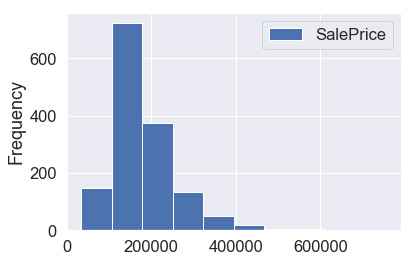

In [47]:
data.plot(y= 'SalePrice',  kind='hist') 

Sale Price Mean: 180921.19589041095
Sale Price Median: 163000.0


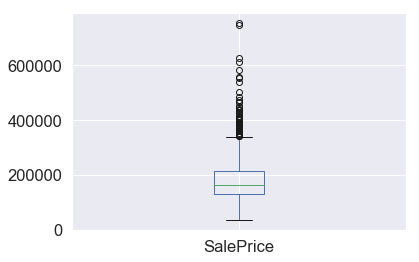

In [48]:
data.plot(y='SalePrice',  kind='box') 
print("Sale Price Mean:", data.SalePrice.mean())
print("Sale Price Median:",np.median(data.SalePrice))

We could see that sales price is **skewed**. The majority of prices is between 100K and 200K, and only a few observation has price over 300K.

So that our models are not compromised by this deviation, we can use the ***log1p*** to scale the Sales Price **before modeling**, then use ***expm1*** on the **predictions** to back to the original scale. As alternative, our first model to try might be Poisson regression, which is equivalent to working on a log scale (specifically, the link function is logarithmic).

Log1P Sale Price Mean: 12.024057394918371
Log1P Sale Price Median: 12.001511614739405


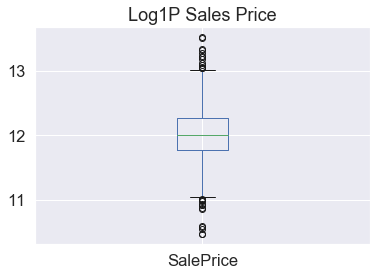

In [49]:
y.plot(y='SalePrice',  kind='box', title='Log1P Sales Price')
print("Log1P Sale Price Mean:", y.mean())
print("Log1P Sale Price Median:",np.median(y))

In [50]:
explorator = all_data.iloc[:data.shape[0], :]
explorator['SalePrice'] = data.SalePrice

numeric_cols = explorator.select_dtypes(exclude=['object']).columns

C:\Users\marce\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


From the graph below, we could notes that only **OverQaul** has good chace to be a good feature to predict price. Maybe **OverCond** could help with other features to identify highest prices.

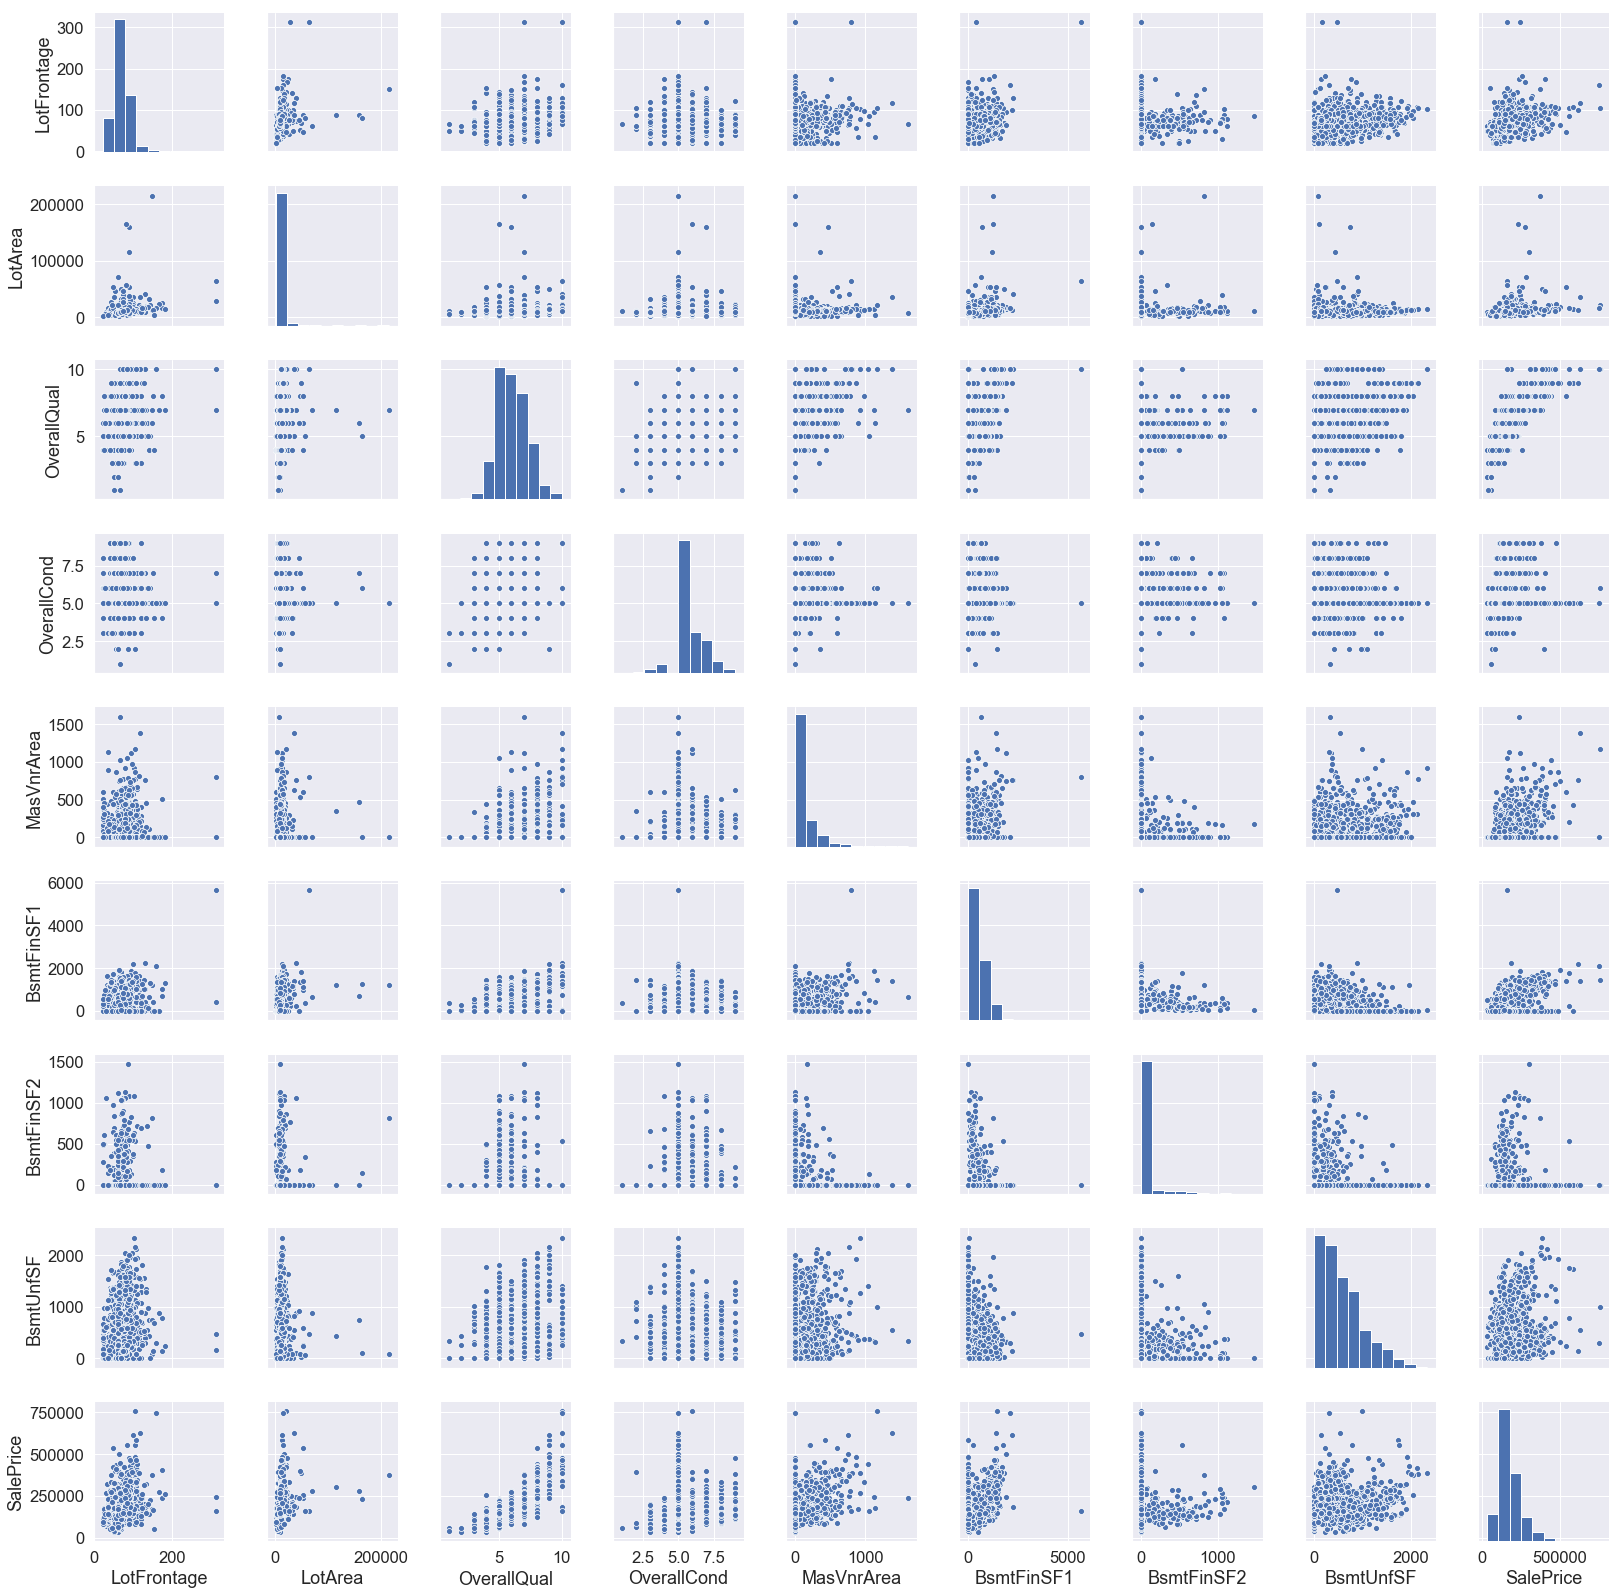

In [51]:
g = sns.pairplot(explorator.loc[:, np.insert(numeric_cols[:8], 8, values='SalePrice')])

From the graph below, we could notes that **GrLivArea**, **TotalBsmtSF** and **1stFlrSF** has good chaces to be a good features to predict price and **2ndFlrSF** could help, but has some 'NA' that maybe cause deviations. Maybe **BsmtFullBath**, **BsmtHalfBath**, **FullBath** could help to identify hiden differencies.

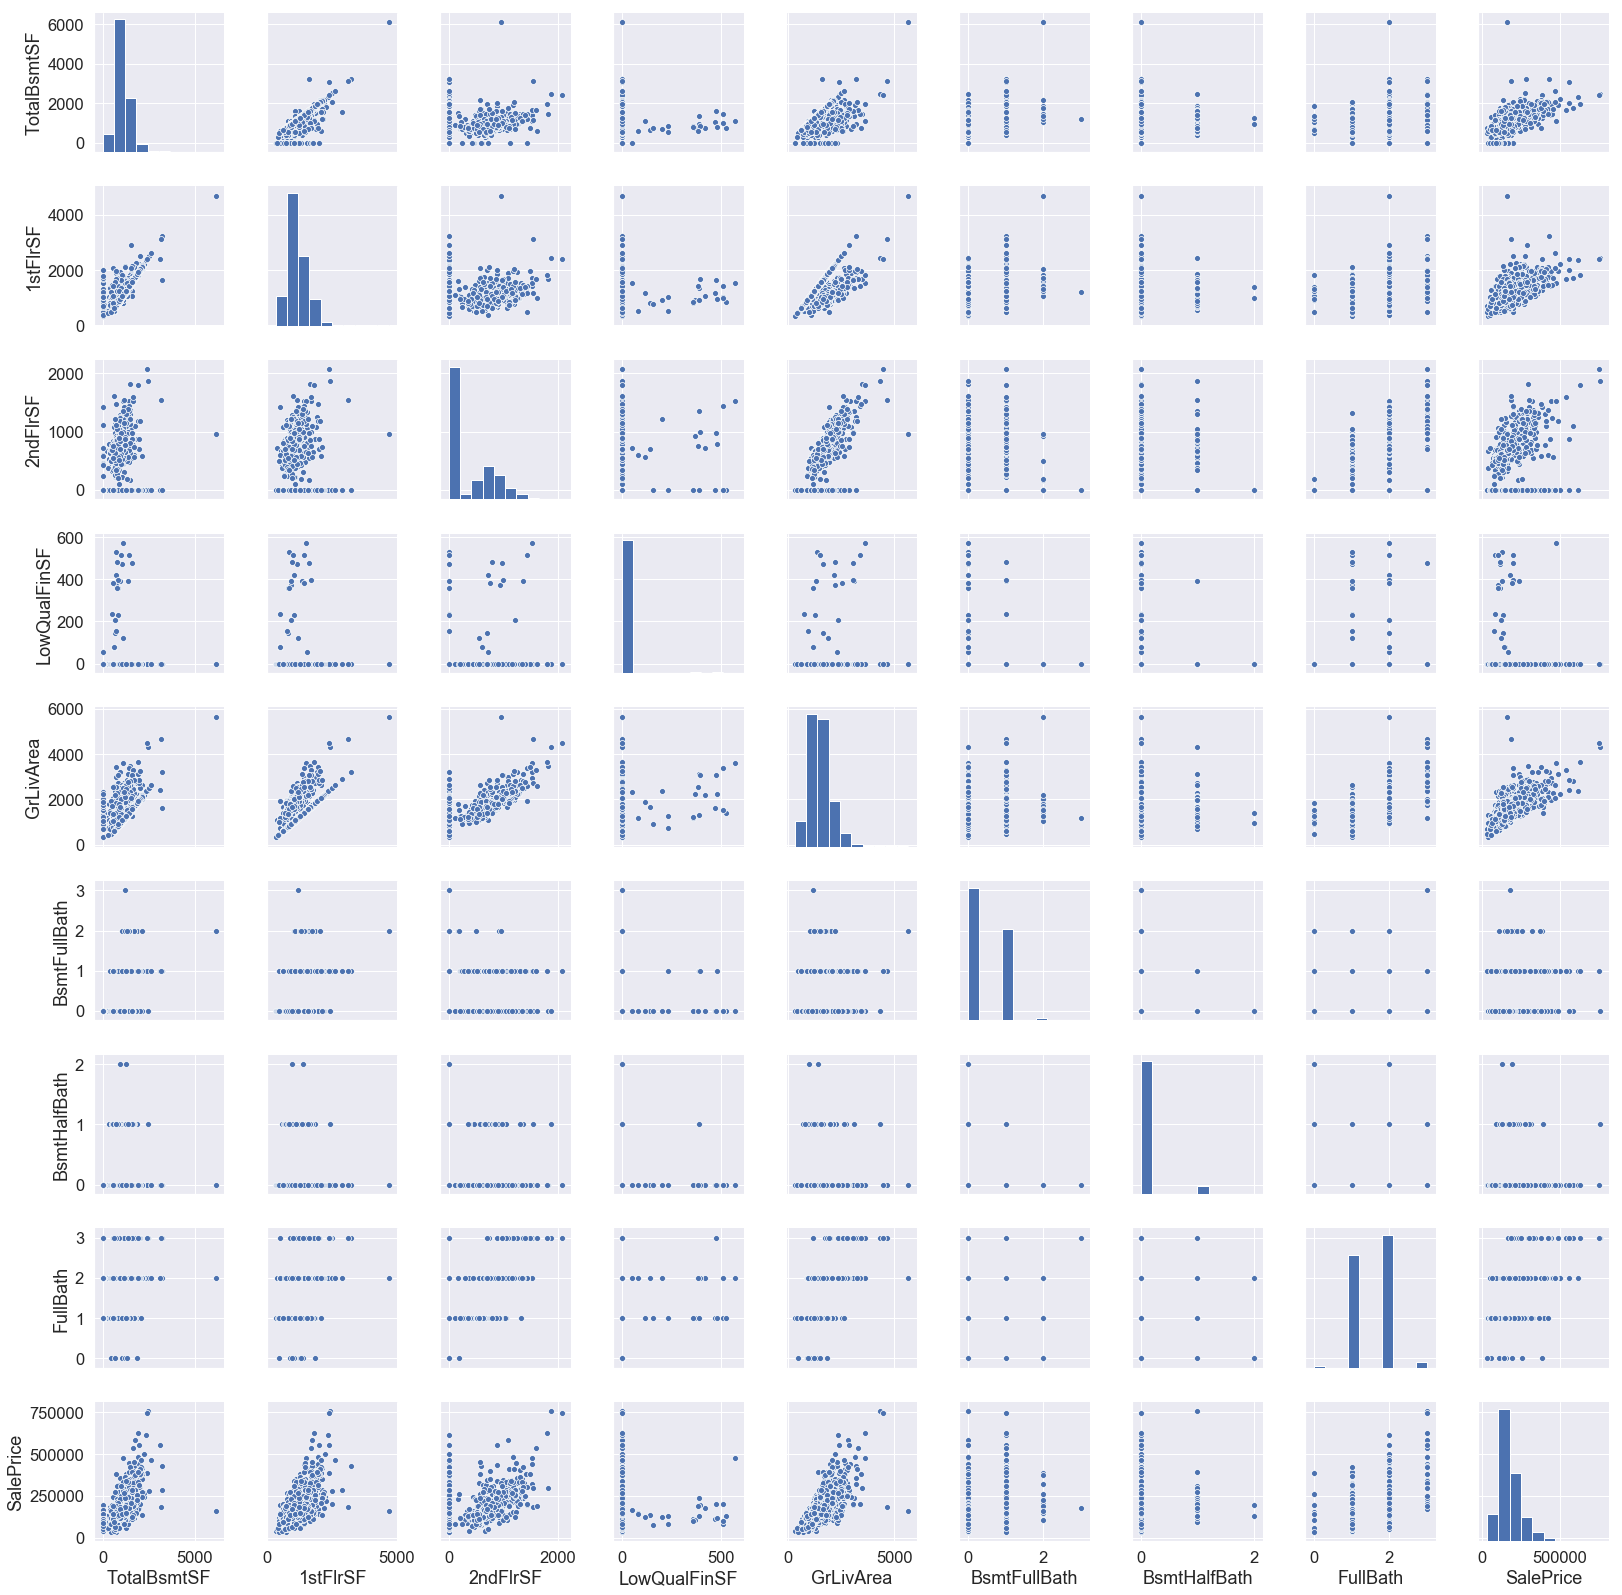

In [52]:
g = sns.pairplot(explorator.loc[:, np.insert(numeric_cols[8:16], 8, values='SalePrice')])

From the graph below, we could notes that **TotRmsAbvGrd** and **GarageArea** has good chace to be a good feature to predict price. Maybe **KitchenAbvGr**, **GarageCars**, **WoodDeckSF** and **Fireplaces** could help with some other features.

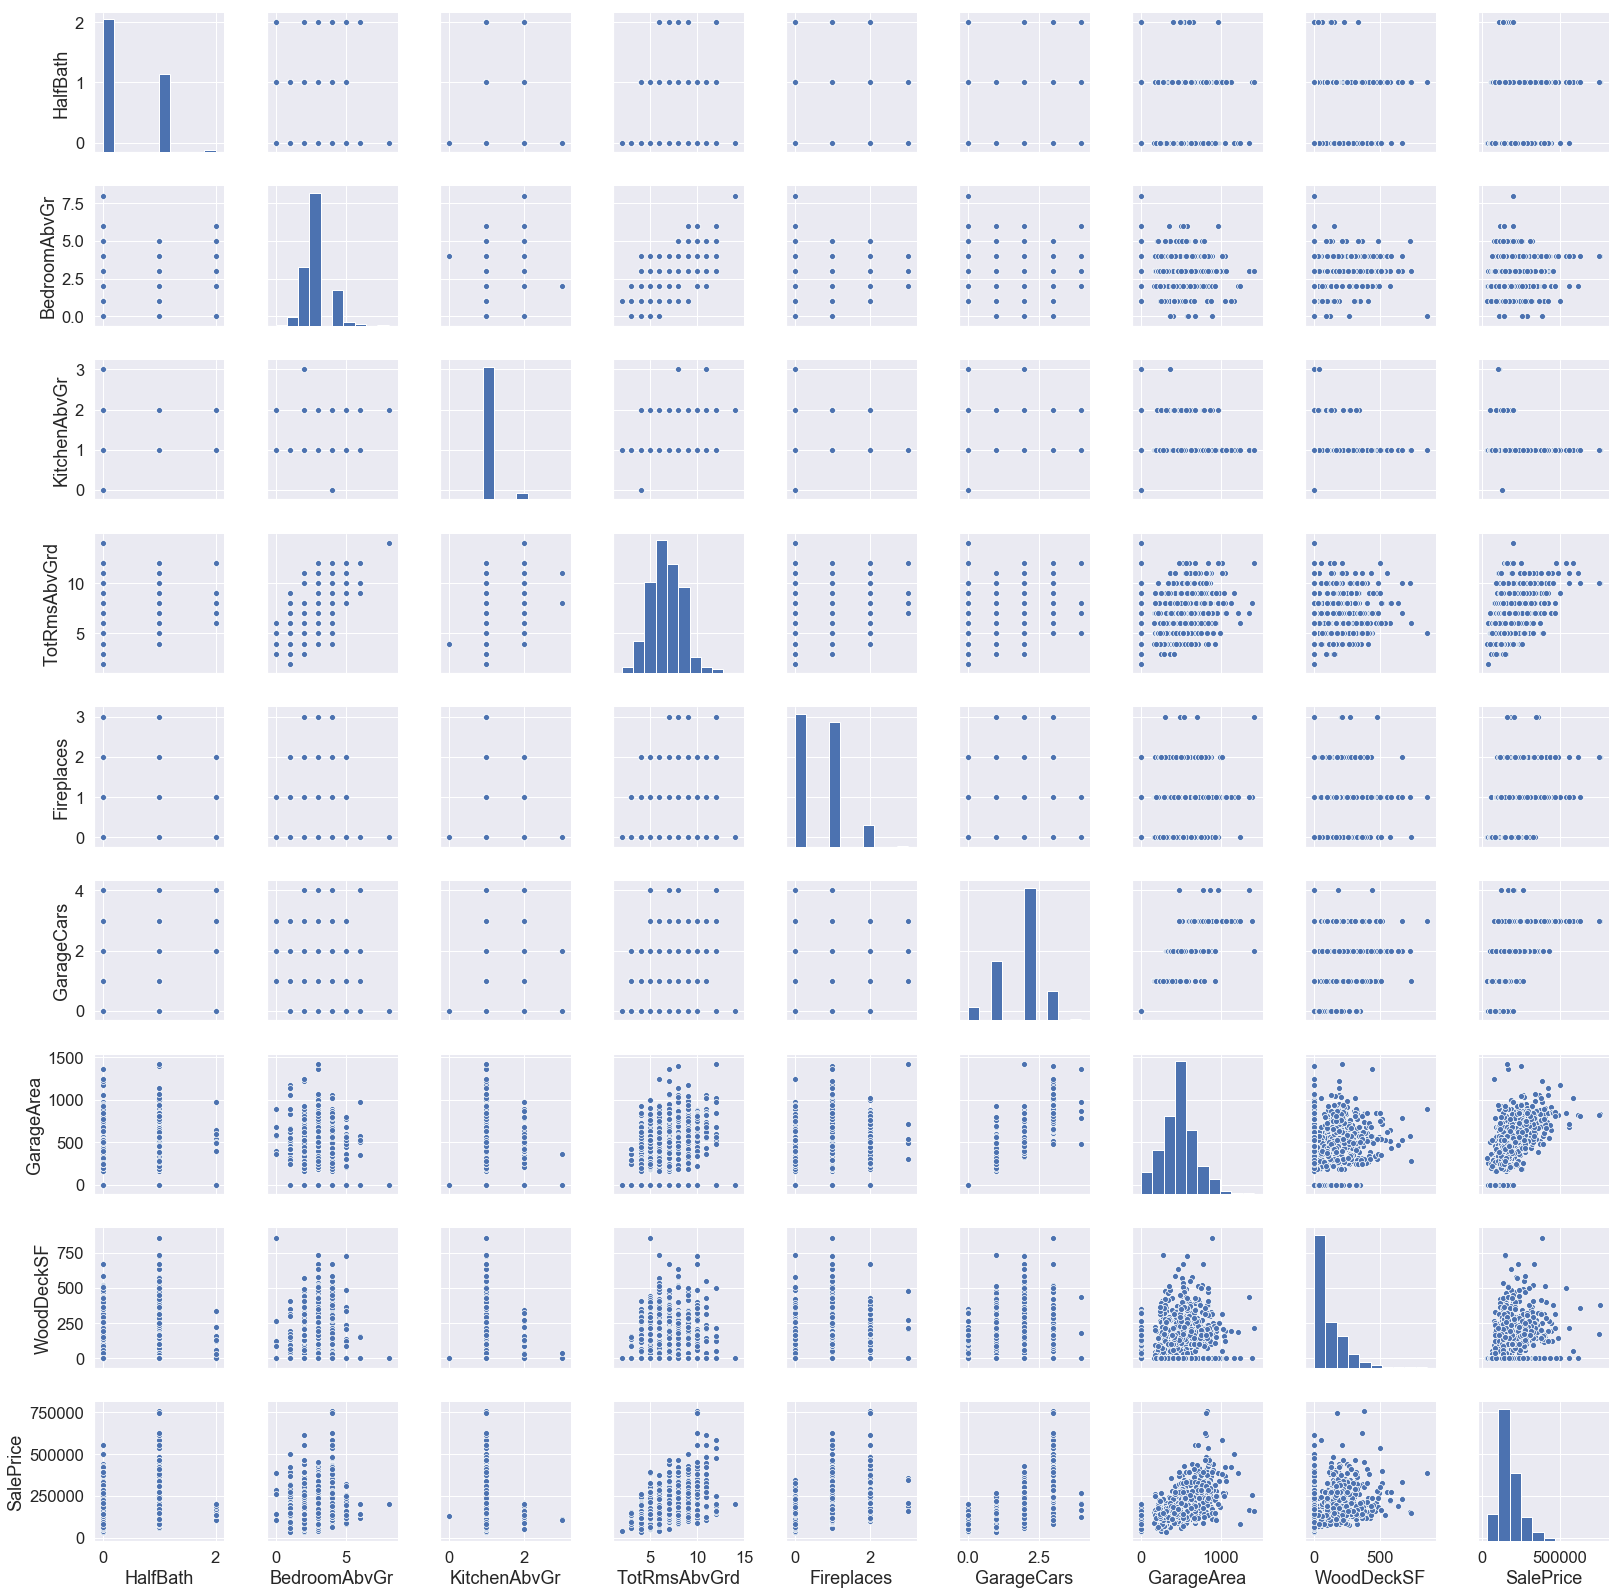

In [53]:
g = sns.pairplot(explorator.loc[:, np.insert(numeric_cols[16:24], 8, values='SalePrice')])

From the graph below, we could see that our created feature **ConstructArea** apears as the best for predict sales price with only two outliers that we could exclude from the training data if they continue skewed after Log1P scale.
Remenber that ***ConstructArea*** was the somation of **TotalBsmtSF**, **GrLivArea** , **OpenPorchSF**, **MasVnrArea**, **GarageArea**, and **PoolArea**, neither then as a excelent predictors insolated, some of then has low bias and high variance and some others has a lot of 'NA'.

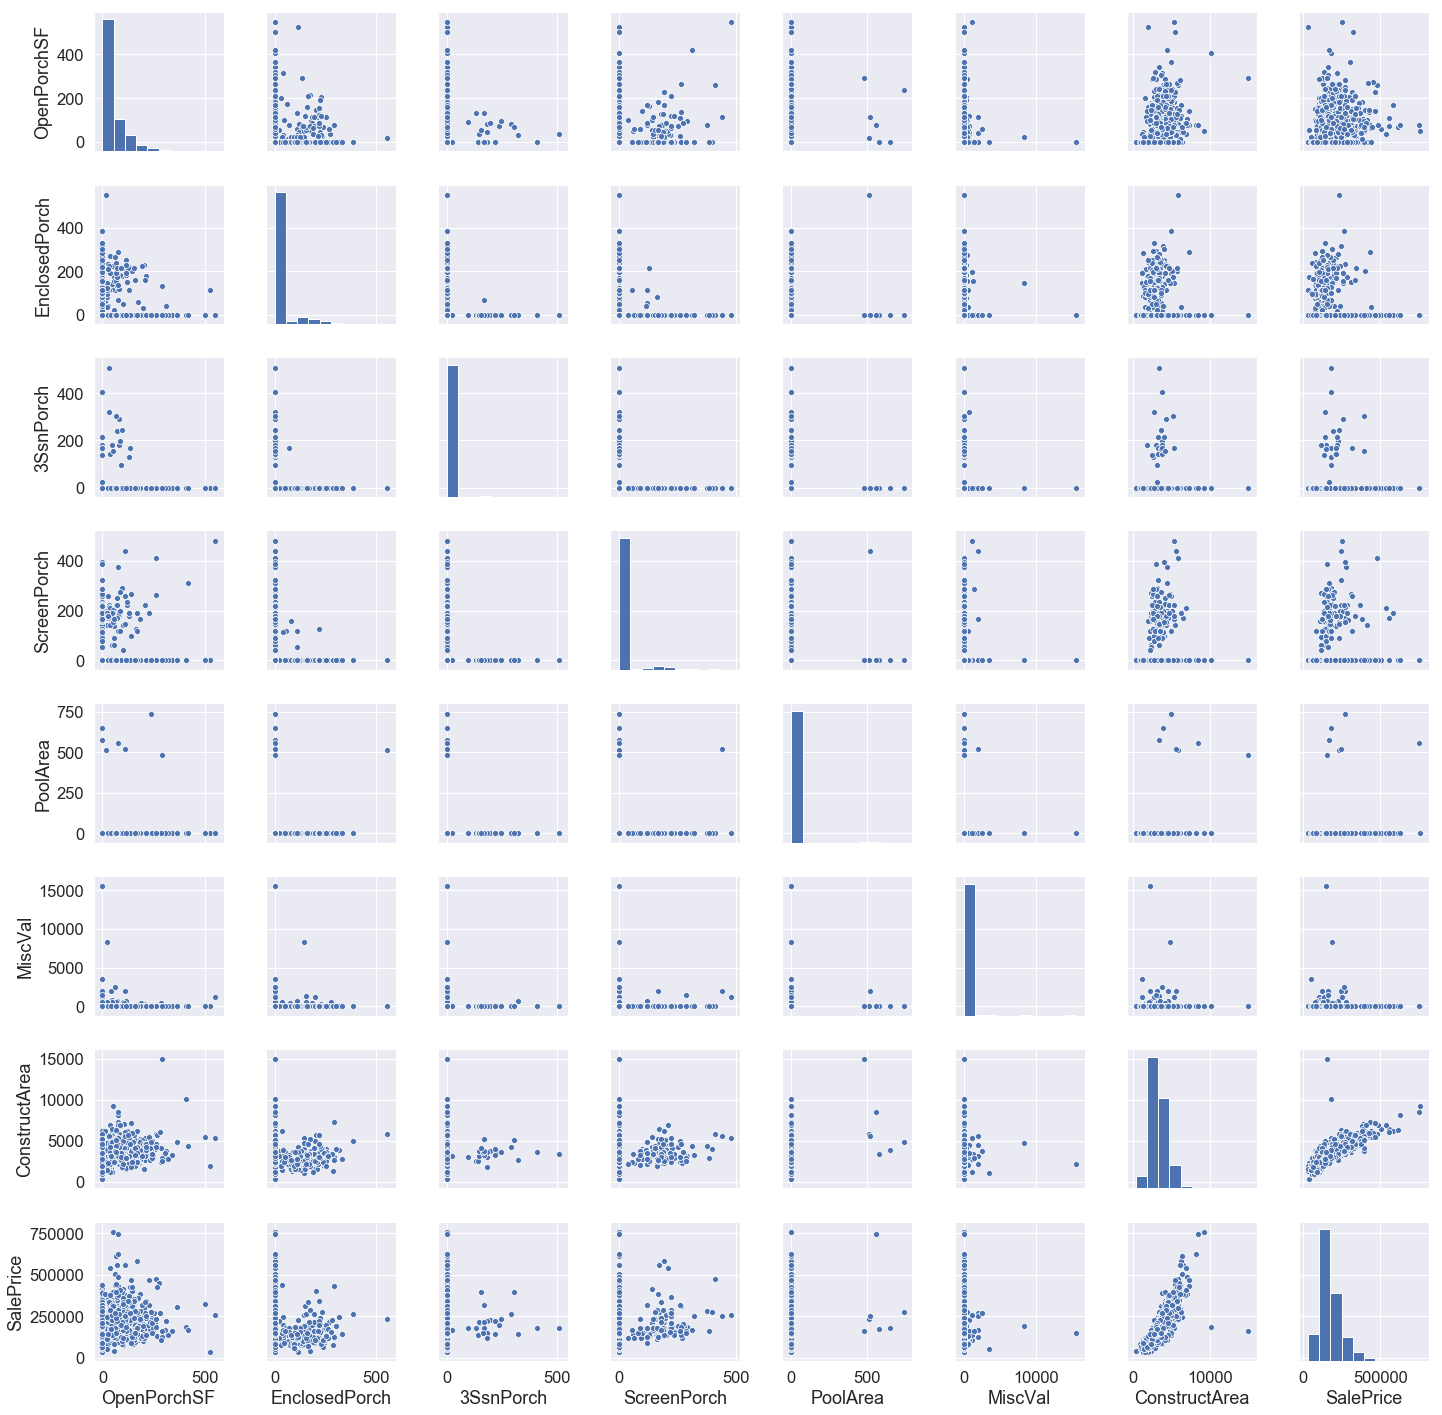

In [54]:
g = sns.pairplot(explorator.loc[:, numeric_cols[24:]])

Outliers: 2


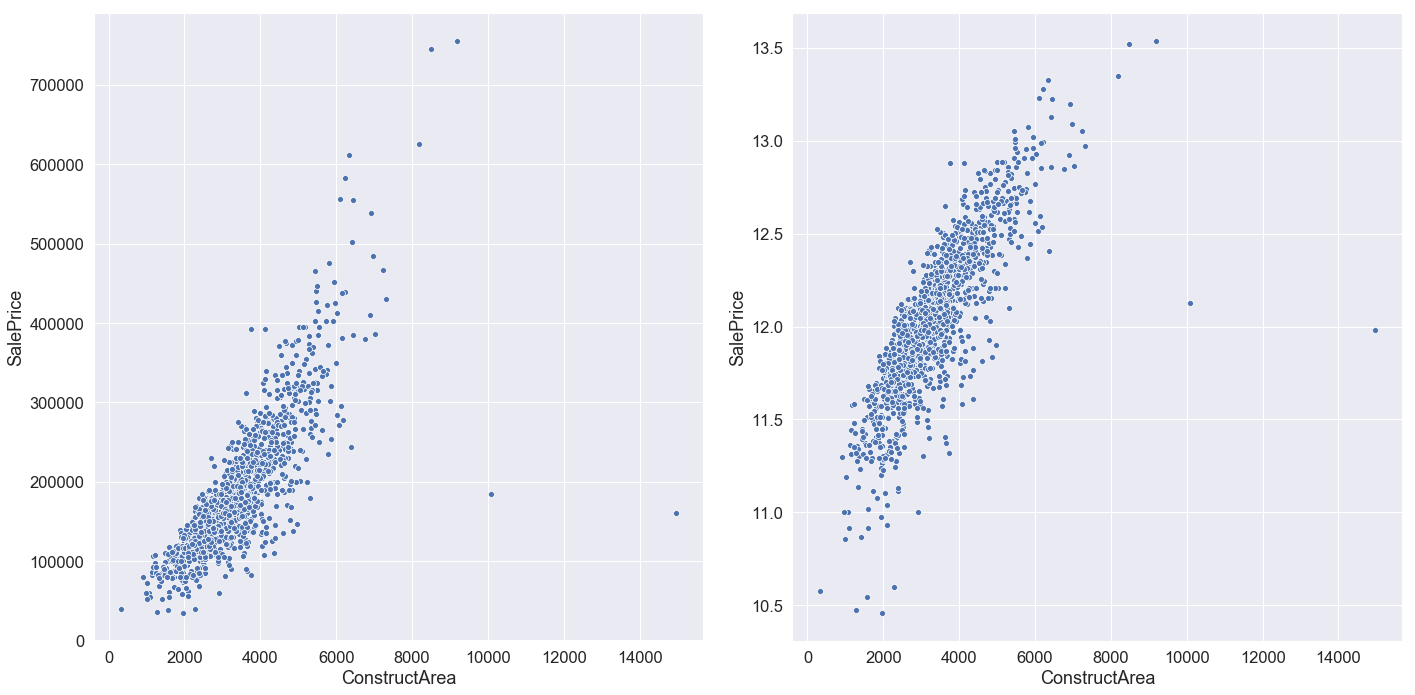

In [55]:
print('Outliers:', explorator[explorator.ConstructArea>10000].shape[0])
fig = plt.figure(figsize=(20,10))

# SalePrice Original
fig1 = fig.add_subplot(121)
sns.scatterplot(x = explorator.ConstructArea, y = explorator.SalePrice)

# SalePrice Log1P
fig2 = fig.add_subplot(122)
sns.scatterplot(x = explorator.ConstructArea, y = y)

plt.tight_layout()
plt.show()

# So, we can cut this two outliers from the training dataset!

## Mapping ordinal features

In [56]:
def map_ordinals(data):
    # LandSlope: Slope of property
    LandSlope = {}
    LandSlope['Gtl'] = 3 #'Gentle slope'
    LandSlope['Mod'] = 2 #'Moderate Slope'
    LandSlope['Sev'] = 1 #'Severe Slope'

    data.LandSlope = data.LandSlope.map(LandSlope)

    # ExterQual: Evaluates the quality of the material on the exterior 
    ExterQual = {}
    ExterQual['Ex'] = 5 #'Excellent'
    ExterQual['Gd'] = 4 #'Good'
    ExterQual['TA'] = 3 #'Average/Typical'
    ExterQual['Fa'] = 2 #'Fair'
    ExterQual['Po'] = 1 #'Poor'
    ExterQual['NA'] = 0 #'NA'

    data.ExterQual = data.ExterQual.map(ExterQual)

    # ExterCond: Evaluates the present condition of the material on the exterior
    data.ExterCond = data.ExterCond.map(ExterQual)

    #HeatingQC: Heating quality and condition
    data.HeatingQC = data.HeatingQC.map(ExterQual)

    # KitchenQual: Kitchen quality
    data.KitchenQual = data.KitchenQual.map(ExterQual)

    # FireplaceQu: Fireplace quality
    data.FireplaceQu = data.FireplaceQu.map(ExterQual)

    # GarageCond: Garage Conditionals
    data.GarageCond = data.GarageCond.map(ExterQual)

    PavedDrive = {}
    PavedDrive['Y'] = 3 #'Paved'
    PavedDrive['P'] = 2 #'Partial Pavement'
    PavedDrive['N'] = 1 #'Dirt/Gravel'

    data.PavedDrive = data.PavedDrive.map(PavedDrive)

    # General shape of property
    LotShape = {}
    LotShape['Reg'] = 4 #'Regular'
    LotShape['IR1'] = 3 #'Slightly irregular'
    LotShape['IR2'] = 2 #'Moderately Irregular'
    LotShape['IR3'] = 1 #'Irregular'

    data.LotShape = data.LotShape.map(LotShape)

    # BsmtQual: Evaluates the height of the basement
    BsmtQual = {}
    BsmtQual['Ex'] = 5 #'Excellent (100+ inches)'
    BsmtQual['Gd'] = 4 #'Good (90-99 inches)'
    BsmtQual['TA'] = 3 #'Typical (80-89 inches)'
    BsmtQual['Fa'] = 2 #'Fair (70-79 inches)'
    BsmtQual['Po'] = 1 #'Poor (<70 inches'
    BsmtQual['NA'] = 0 #'No Basement'

    data.BsmtQual = data.BsmtQual.map(BsmtQual)

    # BsmtCond: Evaluates the general condition of the basement
    data.BsmtCond = data.BsmtCond.map(BsmtQual)

    # GarageQual: Garage quality
    data.GarageQual = data.GarageQual.map(BsmtQual)

    # PoolQC: Pool quality
    data.PoolQC = data.PoolQC.map(BsmtQual)

    # BsmtExposure: Refers to walkout or garden level walls
    BsmtExposure = {}
    BsmtExposure['Gd'] = 4 #'Good Exposure'
    BsmtExposure['Av'] = 3 #'Average Exposure (split levels or foyers typically score average or above)'
    BsmtExposure['Mn'] = 2 #'Mimimum Exposure'
    BsmtExposure['No'] = 1 #'No Exposure'
    BsmtExposure['NA'] = 0 #'No Basement'

    data.BsmtExposure = data.BsmtExposure.map(BsmtExposure)

    # BsmtFinType1: Rating of basement finished area
    BsmtFinType1 = {}
    BsmtFinType1['GLQ'] = 6 #'Good Living Quarters'
    BsmtFinType1['ALQ'] = 5 # 'Average Living Quarters'
    BsmtFinType1['BLQ'] = 4 # 'Below Average Living Quarters'
    BsmtFinType1['Rec'] = 3 # 'Average Rec Room'
    BsmtFinType1['LwQ'] = 2 # 'Low Quality'
    BsmtFinType1['Unf'] = 1 # 'Unfinshed'
    BsmtFinType1['NA'] = 0 #'No Basement'

    data.BsmtFinType1 = data.BsmtFinType1.map(BsmtFinType1)

    # BsmtFinType2: Rating of basement finished area (if multiple types)
    data.BsmtFinType2 = data.BsmtFinType2.map(BsmtFinType1)

    #CentralAir: Central air conditioning
    CentralAir = {}
    CentralAir['N'] = 0
    CentralAir['Y'] = 1

    data.CentralAir = data.CentralAir.map(CentralAir)

    # GarageFinish: Interior finish of the garage
    GarageFinish = {}
    GarageFinish['Fin'] = 3 #'Finished'
    GarageFinish['RFn'] = 2 #'Rough Finished'
    GarageFinish['Unf'] = 1 #'Unfinished'
    GarageFinish['NA'] = 0 #'No Garage'

    data.GarageFinish = data.GarageFinish.map(GarageFinish)

    # Fence: Fence quality
    Fence = {}
    Fence['GdPrv'] = 5 #'Good Privacy'
    Fence['MnPrv'] = 4 #'Minimum Privacy'
    Fence['GdWo'] = 3 #'Good Wood'
    Fence['MnWw'] = 2 #'Minimum Wood/Wire'
    Fence['NA'] = 1 #'No Fence'

    data.Fence = data.Fence.map(Fence)
    
    return data


## One Hot Encode Categorical Features

In [57]:
def one_hot_encode(data):
    categorical_cols = data.select_dtypes(include=['object']).columns

    print(len(categorical_cols), "categorical columns")
    print(categorical_cols)

    data = pd.get_dummies(data, columns = categorical_cols)

    print("Total Columns:",len(data.columns))
    print(data.info())
    
    return data

## Tidy All Data:

In [58]:
all_data = map_ordinals(all_data)
all_data = one_hot_encode(all_data)

30 categorical columns
Index(['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LandContour', 'Utilities',
       'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating',
       'Electrical', 'Functional', 'GarageType', 'GarageYrBlt', 'MiscFeature',
       'MoSold', 'YrSold', 'SaleType', 'SaleCondition'],
      dtype='object')
Total Columns: 284
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Columns: 284 entries, LotFrontage to SaleCondition_Partial
dtypes: float64(11), int64(39), uint8(234)
memory usage: 1.8 MB
None


## Box cox transformation of highly skewed features

In [59]:
skewed_features = skewness.index

lam = 0.15
for feat in skewed_features:
    all_data[feat] = boxcox1p(all_data[feat], lam)

In [60]:
ntrain = data.shape[0]
train = pd.DataFrame(all_data[:ntrain])
train['SalesPrice'] = y

# Cut the two outliers from the tarining data
train = train[train.ConstructArea<=10000]

y_train= train.SalesPrice.values
train = train.drop(['SalesPrice'], axis=1)
                   
ntest = test.shape[0]
test = pd.DataFrame(all_data[ntrain:])

## PCA evaluetion:

In [61]:
scale = MinMaxScaler()
X_s = scale.fit_transform(train)

pca = PCA().fit(X_s) # whiten=True
print('{:6.4%}'.format(sum(pca.explained_variance_ratio_)),"%\n")

for i in np.arange(X_s.shape[1], 80, -1):
    variance_ratio = sum(pca.explained_variance_ratio_[:i])*100
    if variance_ratio < 99.991 and variance_ratio > 99.990:
        print('{:6.4f}% from {:3}'.format(variance_ratio, i))
    elif variance_ratio < 99.050 and variance_ratio >= 99.000:
        print('{:6.4f}% from {:3}'.format(variance_ratio, i))
        best = i
    elif variance_ratio < 98.1 and variance_ratio >= 98.0:
        print('{:6.4f}% from {:3}'.format(variance_ratio, i))
    elif variance_ratio < 97.1 and variance_ratio >= 97.0:
        print('{:6.4f}% from {:3}'.format(variance_ratio, i))
    elif variance_ratio < 96.1 and variance_ratio >= 97.0:
        print('{:6.4f}% from {:3}'.format(variance_ratio, i))
    elif variance_ratio < 95.1 and variance_ratio >= 95.0:
        print('{:6.4f}% from {:3}'.format(variance_ratio, i))

pca = PCA(n_components=best).fit(X_s)
print('After PCA with {:3} features only not explained {:6.4%} of variance ratio from the original {:3}'.format(best,
                                                                                    (1 - sum(pca.explained_variance_ratio_)),
                                                                                    X_s.shape[1]))
del X_s, explorator, all_data

100.0000% %

99.9907% from 242
99.0327% from 167
99.0013% from 166
98.0818% from 144
98.0274% from 143
97.0554% from 128
95.0470% from 108
After PCA with 166 features only not explained 1.0031% of variance ratio from the original 284


# Model Hiperparametrization
## Evaluete Results

In [62]:
def get_results(model):
    results = model.cv_results_

    scoring = {'MEA': 'neg_mean_absolute_error', 'R2': 'r2', 'RMSE': 'neg_mean_squared_error'}

    for scorer in sorted(scoring):
        best_index = np.nonzero(results['rank_test_%s' % scoring[scorer]] == 1)[0][0]
        if scorer == 'RMSE': 
            best = np.expm1(np.sqrt(-results['mean_test_%s' % scoring[scorer]][best_index]))
            best_std = np.expm1(np.sqrt(results['std_test_%s' % scoring[scorer]][best_index]))
            scormean = np.expm1(np.sqrt(-results['mean_test_%s' % scoring[scorer]].mean()))
            stdmean = np.expm1(np.sqrt(results['std_test_%s' % scoring[scorer]].mean()))
        elif scorer == 'MEA':
            best = np.expm1(-results['mean_test_%s' % scoring[scorer]][best_index])
            best_std = np.expm1(results['std_test_%s' % scoring[scorer]][best_index])
            scormean = np.expm1(-results['mean_test_%s' % scoring[scorer]].mean())
            stdmean = np.expm1(results['std_test_%s' % scoring[scorer]].mean())
        else:
            best = results['mean_test_%s' % scoring[scorer]][best_index]*100
            best_std = results['std_test_%s' % scoring[scorer]][best_index]*100
            scormean = results['mean_test_%s' % scoring[scorer]].mean()*100
            stdmean = results['std_test_%s' % scoring[scorer]].mean()*100
        
        print("Best %s Score:" % scorer )
        print('Best index = ', best_index)
        print('Best score = {:.6f}  -  ({:.6f})'.format(best,best_std))
        print('Mean score = {:.6f}  -  ({:.6f})'.format(scormean,stdmean))
        print('---------------------------------------')

    print("Best Score: {:.6f}".format(model.best_score_))
    print('---------------------------------------')
    print('Best Parameters:')
    print(model.best_params_)

In [ ]:
#validation function
n_folds = 5

def RMSLE_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error",
cv = kf))
    return(rmse)

## Lasso Hiperparametrization

In [171]:
lasso = Pipeline([
    ('scl', RobustScaler()),
    #('pca', PCA(random_state = 101)),
    ('model', Lasso(random_state = 101))
])
'''
Best Score: 0.924420
---------------------------------------
Best Parameters:
{'model__alpha': 0.0005, 'model__max_iter': 200, 'model__selection': 'random'}

Best Score: 0.924420
---------------------------------------
Best Parameters:
{'model__alpha': 0.0005, 'model__max_iter': 200, 'model__selection': 'random'}
'''
n_components= [167, 242, 284]
whiten = [True, False]

max_iter= [221] # np.arange(219,230) #[50, 100, 200, 500]
alpha = [0.0005, 0.0001] # , 0.005, 0.05, 0.5, 1.0
selection = ['random', 'cyclic']
tol = [0.000001 , 0.00001]


reg = GridSearchCV(estimator = lasso, 
                   param_grid = dict(
#                       pca__n_components = n_components
#                      ,pca__whiten = whiten 
                       model__alpha = alpha
                      ,model__max_iter = max_iter
                      ,model__selection = selection
                      ,model__tol = tol
                   ) 
                   ,refit = 'r2', scoring=list(['neg_mean_squared_error' , 'neg_mean_absolute_error', 'r2']) 
                   ,cv=10, verbose=1, n_jobs=3)

reg.fit(train, y_train)
get_results(reg)

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    4.7s


Best MEA Score:
Best index =  0
Best score = 0.080662  -  (0.004426)
Mean score = 0.081217  -  (0.004439)
---------------------------------------
Best R2 Score:
Best index =  0
Best score = 92.441910  -  (1.270338)
Mean score = 92.202815  -  (1.314888)
---------------------------------------
Best RMSE Score:
Best index =  0
Best score = 0.116226  -  (0.057265)
Mean score = 0.118146  -  (0.058042)
---------------------------------------
Best Score: 0.924419
---------------------------------------
Best Parameters:
{'model__alpha': 0.0005, 'model__max_iter': 221, 'model__selection': 'random', 'model__tol': 1e-06}


[Parallel(n_jobs=3)]: Done  80 out of  80 | elapsed:    7.4s finished
C:\Users\marce\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


## XGBRegressor Hiperparametrization

In [72]:
XGBR = Pipeline([
    ('scl', RobustScaler()),
    #('pca', PCA(random_state=101)),
    ('model', XGBRegressor(base_score=0.5, colsample_bylevel=1,
       colsample_bytree=1, gamma=0, max_delta_step=0, random_state=101,
       min_child_weight=1, missing=None, n_jobs=3, nthread=None, 
       scale_pos_weight=1, seed=None, silent=True, subsample=1))])

#n_components= [262] # [167, 242, 284]
#whiten = [True] # [True, False]
n_est = np.arange(1997, 2009, 3) # 500, 750, 1000, 3000, 5000 np.arange(1249, 1300, 3)
max_depth = [3] # 2,4, 5, 10
learning_rate = [0.01] # 0.001, 0.1, 0.05
reg_lambda = [1] #, 0.10]
reg_alpha= [0] # , 0.5, 1]
#booster = ['dart'] # 'gblinear' estora
#objective = ['reg:linear', 'reg:gamma', 'reg:tweedie']

reg2 = GridSearchCV(estimator = XGBR, 
                   param_grid = dict(
                      model__n_estimators= n_est
                      #,pca__n_components = n_components
                      #,pca__whiten = whiten 
                      #,model__booster = booster
                      #,model__objective = objective
                      ,model__learning_rate = learning_rate
                      ,model__reg_lambda = reg_lambda
                      ,model__reg_alpha = reg_alpha
                      ,model__max_depth = max_depth
                   ) 
                   ,refit = 'r2', scoring=list(['neg_mean_squared_error' , 'neg_mean_absolute_error', 'r2']) 
                   ,cv=6, verbose=2, n_jobs=3)

reg2.fit(train, y_train)

Fitting 6 folds for each of 4 candidates, totalling 24 fits


[Parallel(n_jobs=3)]: Done  24 out of  24 | elapsed:  2.7min finished


GridSearchCV(cv=6, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scl', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('model', XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_we...
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))]),
       fit_params=None, iid=True, n_jobs=3,
       param_grid={'model__n_estimators': array([1997, 2000, 2003, 2006]), 'model__learning_rate': [0.01], 'model__reg_lambda': [1], 'model__reg_alpha': [0], 'model__max_depth': [3]},
       pre_dispatch='2*n_jobs', refit='r2', return_train_score='warn',
       scoring=['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2'],
       verbose=2)

### Results from the XGBRegressor

In [73]:
get_results(reg2)
#reg2.feature_importances_
#reg2.booster().get_score(importance_type='weight')

Best MEA Score:
Best index =  3
Best score = 0.085065  -  (0.002390)
Mean score = 0.085076  -  (0.002389)
---------------------------------------
Best R2 Score:
Best index =  3
Best score = 91.477092  -  (1.257489)
Mean score = 91.476003  -  (1.257547)
---------------------------------------
Best RMSE Score:
Best index =  3
Best score = 0.123364  -  (0.046628)
Mean score = 0.123372  -  (0.046624)
---------------------------------------
Best Score: 0.914771
---------------------------------------
Best Parameters:
{'model__learning_rate': 0.01, 'model__max_depth': 3, 'model__n_estimators': 2006, 'model__reg_alpha': 0, 'model__reg_lambda': 1}


## Random Forest Regressor Hiperparametrization

In [ ]:
RF = Pipeline([
    ('scl', RobustScaler()),
    ('pca', PCA(random_state=101)),
    ('model', RandomForestRegressor(criterion = 'mae', random_state=101))
    ])

n_components= [242]
whiten = [True, False]
n_estimators = [3000] #np.arange(50, 90, 2) 100, 500, 1000, 2000, 
max_depth  = [2, 3, 4, 5, 10] # 
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 5 , 15]

reg3 = GridSearchCV(estimator = RF, param_grid = dict(
                      pca__n_components = n_components
                      ,pca__whiten = whiten 
                      ,model__n_estimators = n_estimators 
                      #,model__max_depth = max_depth
                      #,model__min_samples_split = min_samples_split
                      #,model__min_samples_leaf = min_samples_leaf
                        ) 
                      ,refit = 'r2', scoring=list(['neg_mean_squared_error' , 
                                                                        'neg_mean_absolute_error', 'r2']) 
                      ,cv=6, verbose=1, n_jobs=3)

reg3.fit(train, y_train)

Fitting 6 folds for each of 6 candidates, totalling 36 fits


### Results from the Random Forest Regressor 

In [ ]:
get_results(reg3)
#reg3.best_estimator_.feature_importances_ 

##  Gradient Boosting Regressor Hiperparametrization

In [63]:
'''
400 md 5 mss 2lr 0.1 loss ls
Hiperparameter focos: learning_rate=0.1, n_estimators=100, max_depth=3
Set changes: random_state=101, verbose=3

Other Parameters: min_samples_split=2, loss='ls', subsample=1.0, criterion='friedman_mse', 
     min_samples_leaf=1, min_weight_fraction_leaf=0.0, min_impurity_decrease=0.0, min_impurity_split=None, 
     init=None, max_features=None, alpha=0.9, max_leaf_nodes=None, warm_start=False, presort='auto'
'''
my_model = Pipeline([
    ('scl', RobustScaler()),
    #('pca', PCA(random_state=101)),
    ('model', ensemble.GradientBoostingRegressor(random_state=101))
    ])

'''
loss = ['ls', 'lad', 'huber', 'quantile'] huber is de combination of ls and land, ls is the default
If int, then consider max_features features at each split.
If float, then max_features is a percentage and int(max_features * n_features) features are considered at each split.
If “auto”, then max_features=n_features.
If “sqrt”, then max_features=sqrt(n_features).
If “log2”, then max_features=log2(n_features).
If None, then max_features=n_features.
'''
n_est = [759] # np.arange(750, 760, 1) # [300, 750, 1000, 3000]
learning_rate = [0.05] # , 0.1, 0.001]
loss = ['ls', 'huber'] # , 'lad', 'quantile']
max_features = ['sqrt'] #, 'auto', 'log2']
max_depth = [3] # 2 , 4, 5
min_samples_split = [4] #2, 3, 5, 7, 10]
min_samples_leaf = [1] # , 5 , 15]
criterion = ['friedman_mse'] #, 'mse', 'mae']


reg4 = GridSearchCV(estimator = my_model, param_grid = dict(
#                       pca__n_components = n_components
#                      ,pca__whiten = whiten 
                       model__n_estimators= n_est 
                      ,model__learning_rate = learning_rate
                      ,model__loss = loss
                      ,model__criterion = criterion
                      ,model__max_depth = max_depth
                      ,model__max_features = max_features
                      ,model__min_samples_split = min_samples_split
                      ,model__min_samples_leaf = min_samples_leaf
                       )
                      ,refit = 'r2', scoring=list(['neg_mean_squared_error' , 
                                                   'neg_mean_absolute_error', 'r2']) 
                      ,cv=6, verbose=1, n_jobs=3)

reg4.fit(train, y_train)

Fitting 6 folds for each of 2 candidates, totalling 12 fits


[Parallel(n_jobs=3)]: Done  12 out of  12 | elapsed:   14.3s finished


GridSearchCV(cv=6, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scl', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('model', GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_no...rs=100, presort='auto', random_state=101,
             subsample=1.0, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=3,
       param_grid={'model__n_estimators': [759], 'model__learning_rate': [0.05], 'model__loss': ['ls', 'huber'], 'model__criterion': ['friedman_mse'], 'model__max_depth': [3], 'model__max_features': ['sqrt'], 'model__min_samples_split': [4], 'model__min_samples_leaf': [1]},
       pre_dispatch='2*n_jobs', refit='r2', return_train_score='warn',
       scoring=['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2'],
       verbose=1)

In [64]:
get_results(reg4)
#reg4.best_estimator_.feature_importances_

Best MEA Score:
Best index =  1
Best score = 0.081630  -  (0.003675)
Mean score = 0.081991  -  (0.004001)
---------------------------------------
Best R2 Score:
Best index =  0
Best score = 91.901131  -  (1.087085)
Mean score = 91.872370  -  (1.110006)
---------------------------------------
Best RMSE Score:
Best index =  0
Best score = 0.120588  -  (0.052067)
Mean score = 0.120729  -  (0.051153)
---------------------------------------
Best Score: 0.919011
---------------------------------------
Best Parameters:
{'model__criterion': 'friedman_mse', 'model__learning_rate': 0.05, 'model__loss': 'ls', 'model__max_depth': 3, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 1, 'model__min_samples_split': 4, 'model__n_estimators': 759}


In [107]:
from sklearn.linear_model import ElasticNet

In [120]:
ELA = Pipeline([
    ('scl', RobustScaler()),
    ('pca', PCA(random_state=101)),
    ('model', ElasticNet(random_state=101))
])

n_components= [262] # [167, 242, 278 284]
whiten = [False] # True, 

max_iter = [2] # np.arange(2, 101) 50, 20 500, 1000, 2000, 3000, 5000] 
alpha = [0.0001]  # [0.001, 0.00001, 1.0, 0.5, 0.01, 0.0]
l1_ratio = [1.0] #, 0.5, 0.01, 0.0] 
selection = ['cyclic', 'random']

reg5 = GridSearchCV(estimator = ELA, 
                   param_grid = dict(
                      model__max_iter= max_iter
                      ,pca__n_components = n_components
                      ,pca__whiten = whiten 
                      ,model__alpha = alpha
                      ,model__l1_ratio = l1_ratio
                      ,model__selection = selection
                   ) 
                   ,refit = 'r2', scoring=list(['neg_mean_squared_error' , 'neg_mean_absolute_error', 'r2']) 
                   ,cv=6, verbose=1, n_jobs=3)

reg5.fit(train, y_train)

Fitting 6 folds for each of 2 candidates, totalling 12 fits


[Parallel(n_jobs=3)]: Done  12 out of  12 | elapsed:    3.1s finished


GridSearchCV(cv=6, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scl', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=101,
  svd_solver='auto', tol=0.0, whiten=False)), ('model', Elastic...alse, precompute=False,
      random_state=101, selection='cyclic', tol=0.0001, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=3,
       param_grid={'model__max_iter': [2], 'pca__n_components': [262], 'pca__whiten': [False], 'model__alpha': [0.0001], 'model__l1_ratio': [1.0], 'model__selection': ['cyclic', 'random']},
       pre_dispatch='2*n_jobs', refit='r2', return_train_score='warn',
       scoring=['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2'],
       verbose=1)

In [121]:
get_results(reg5)

Best MEA Score:
Best index =  0
Best score = 0.082530  -  (0.002570)
Mean score = 0.136533  -  (0.006059)
---------------------------------------
Best R2 Score:
Best index =  0
Best score = 91.834408  -  (0.815382)
Mean score = 78.225869  -  (2.217545)
---------------------------------------
Best RMSE Score:
Best index =  0
Best score = 0.120991  -  (0.047239)
Mean score = 0.204477  -  (0.068179)
---------------------------------------
Best Score: 0.918344
---------------------------------------
Best Parameters:
{'model__alpha': 0.0001, 'model__l1_ratio': 1.0, 'model__max_iter': 2, 'model__selection': 'cyclic', 'pca__n_components': 262, 'pca__whiten': False}


In [135]:
from sklearn.linear_model import BayesianRidge

In [149]:
BayR = Pipeline([
    ('scl', RobustScaler()),
    ('pca', PCA(random_state = 101)),
    ('model', BayesianRidge())
])

n_components= [212, 232]  # 262, 284
whiten = [False] # True, 
n_iter= np.arange(1, 50) # , 50, 70, 100, 200, 300, 500, 700, 1000]
alpha_1 = [1e-06] # , 1e-04, 1e-03, 1e-02, 1e-05, 0.1]
alpha_2 = [0.01] # 1e-02, 1e-06, 1e-04, 1e-03, 1e-02, 0.1]
lambda_1 = [1e-06] #, 1e-04, 1e-03, 1e-02, 1e-05, 0.1]
lambda_2 = [0.001] # 1e-06, 1e-04, 1e-03, 1e-02, 0.1]

reg6 = GridSearchCV(estimator = BayR, 
                   param_grid = dict(
                       pca__n_components = n_components
                      ,pca__whiten = whiten 
                      ,model__n_iter = n_iter
                      ,model__alpha_1 = alpha_1
                      ,model__alpha_2 = alpha_2
                      ,model__lambda_1 = lambda_1
                      ,model__lambda_2 = lambda_2
                   ) 
                   ,refit = 'r2', scoring=list(['neg_mean_squared_error' , 'neg_mean_absolute_error', 'r2']) 
                   ,cv=6, verbose=1, n_jobs=3)

reg6.fit(train, y_train)
get_results(reg6)

Fitting 6 folds for each of 98 candidates, totalling 588 fits


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    6.9s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:   24.6s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:   55.5s
[Parallel(n_jobs=3)]: Done 588 out of 588 | elapsed:  1.3min finished


Best MEA Score:
Best index =  6
Best score = 0.081423  -  (0.002785)
Mean score = 0.081538  -  (0.002732)
---------------------------------------
Best R2 Score:
Best index =  6
Best score = 92.104110  -  (0.917372)
Mean score = 92.077886  -  (0.912399)
---------------------------------------
Best RMSE Score:
Best index =  6
Best score = 0.118788  -  (0.046604)
Mean score = 0.118997  -  (0.046588)
---------------------------------------
Best Score: 0.921041
---------------------------------------
Best Parameters:
{'model__alpha_1': 1e-06, 'model__alpha_2': 0.01, 'model__lambda_1': 1e-06, 'model__lambda_2': 0.001, 'model__n_iter': 4, 'pca__n_components': 212, 'pca__whiten': False}


In [84]:
from sklearn.linear_model import LinearRegression

LR = Pipeline([
    ('scl', RobustScaler()),
    ('pca', PCA(random_state=101)),
    ('model', LinearRegression())
])

n_components=  [242, 283]
whiten = [True, False]

reg7 = GridSearchCV(estimator = LR, 
                   param_grid = dict(
                      pca__n_components = n_components
                      ,pca__whiten = whiten
                   ) 
                   ,refit = 'r2', scoring=list(['neg_mean_squared_error' , 'neg_mean_absolute_error', 'r2']) 
                   ,cv=6, verbose=1, n_jobs=3)

reg7.fit(train, y_train)

In [105]:
get_results(reg7)

Best MEA Score:
Best index =  1
Best score = 0.086774  -  (0.003789)
Mean score = inf  -  (inf)
---------------------------------------
Best R2 Score:
Best index =  0
Best score = 90.765053  -  (0.731160)
Mean score = -801224984941611643557642240.000000  -  (998003768903235567580348416.000000)
---------------------------------------
Best RMSE Score:
Best index =  0
Best score = 0.129303  -  (0.051177)
Mean score = inf  -  (inf)
---------------------------------------
Best Score: 0.907651
---------------------------------------
Best Parameters:
{'pca__n_components': 242, 'pca__whiten': True}


C:\Users\marce\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in expm1
  app.launch_new_instance()
C:\Users\marce\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in expm1
C:\Users\marce\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in expm1
  # This is added back by InteractiveShellApp.init_path()
C:\Users\marce\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in expm1
  if sys.path[0] == '':


## OrthogonalMatchingPursuit

In [164]:
from sklearn.linear_model import OrthogonalMatchingPursuit

ORT = Pipeline([
    ('scl', RobustScaler()),
    ('pca', PCA(random_state=101)),
    ('model', OrthogonalMatchingPursuit())
])

# 91.769815
n_components= [204] # np.arange(204, 232)
whiten = [True] # , False]
tol = [0.00005, 0.00003, 0.00007]

reg8 = GridSearchCV(estimator = ORT, 
                   param_grid = dict(
                       model__tol = tol
                       ,pca__n_components = n_components
                       ,pca__whiten = whiten
                   ) 
                   ,refit = 'r2', scoring=list(['neg_mean_squared_error' , 'neg_mean_absolute_error', 'r2']) 
                   ,cv=6, verbose=1, n_jobs=3)

reg8.fit(train, y_train)
get_results(reg8)

Fitting 6 folds for each of 3 candidates, totalling 18 fits


[Parallel(n_jobs=3)]: Done  18 out of  18 | elapsed:    4.5s finished


Best MEA Score:
Best index =  0
Best score = 0.083779  -  (0.004147)
Mean score = 0.083779  -  (0.004147)
---------------------------------------
Best R2 Score:
Best index =  0
Best score = 91.769815  -  (1.009187)
Mean score = 91.769815  -  (1.009187)
---------------------------------------
Best RMSE Score:
Best index =  0
Best score = 0.121606  -  (0.050931)
Mean score = 0.121606  -  (0.050931)
---------------------------------------
Best Score: 0.917698
---------------------------------------
Best Parameters:
{'model__tol': 5e-05, 'pca__n_components': 204, 'pca__whiten': True}


C:\Users\marce\Anaconda3\lib\site-packages\sklearn\linear_model\omp.py:657: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  return_n_iter=True)


## HuberRegressor

In [147]:
from sklearn.linear_model import HuberRegressor

Hub = Pipeline([
    ('scl', RobustScaler()),
    ('pca', PCA(random_state=101)),
    ('model', HuberRegressor())
])

n_components= [242, 222] # 278, 284
whiten = [False] # , True] 
max_iter = np.arange(450, 550) # 50, 100, , 1000
alpha = [1.0] # , 0.5, 0.01, 0.001, 0.0001, 0.00001
epsilon = [1.01, 1.005, 1.001] 

reg9 = GridSearchCV(estimator = Hub, 
                   param_grid = dict(
                      model__max_iter= max_iter
                      ,pca__n_components = n_components
                      ,pca__whiten = whiten 
                      ,model__alpha = alpha
                      ,model__epsilon = epsilon
                   ) 
                   ,refit = 'r2', scoring=list(['neg_mean_squared_error' , 'neg_mean_absolute_error', 'r2']) 
                   ,cv=6, verbose=1, n_jobs=3)

reg9.fit(train, y_train)

get_results(reg9)

Fitting 6 folds for each of 600 candidates, totalling 3600 fits


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   43.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  3.1min
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:  7.1min
[Parallel(n_jobs=3)]: Done 794 tasks      | elapsed: 13.0min
[Parallel(n_jobs=3)]: Done 1244 tasks      | elapsed: 20.9min
[Parallel(n_jobs=3)]: Done 1794 tasks      | elapsed: 29.8min
[Parallel(n_jobs=3)]: Done 2444 tasks      | elapsed: 41.1min
[Parallel(n_jobs=3)]: Done 3194 tasks      | elapsed: 53.5min
[Parallel(n_jobs=3)]: Done 3600 out of 3600 | elapsed: 61.1min finished


Best MEA Score:
Best index =  221
Best score = 0.079972  -  (0.003814)
Mean score = 0.080288  -  (0.004000)
---------------------------------------
Best R2 Score:
Best index =  221
Best score = 92.156665  -  (0.851922)
Mean score = 92.119309  -  (0.875684)
---------------------------------------
Best RMSE Score:
Best index =  221
Best score = 0.118397  -  (0.046694)
Mean score = 0.118738  -  (0.047756)
---------------------------------------
Best Score: 0.921567
---------------------------------------
Best Parameters:
{'model__alpha': 1.0, 'model__epsilon': 1.005, 'model__max_iter': 460, 'pca__n_components': 222, 'pca__whiten': False}


## ARDRegression

In [167]:
from sklearn.linear_model import ARDRegression
ARDR = Pipeline([
    ('scl', RobustScaler()),
    ('pca', PCA(random_state = 101)),
    ('model', ARDRegression())
])

n_components= [232, 242]  # 262, 284, 272
whiten = [False] # , True] 
n_iter=  [25, 50, 70] # np.arange(1, 70)
alpha_1 = [1e-06, 1e-5] # , 1e-04, 1e-03, 1e-02, 1e-05, 0.1]
alpha_2 = [1e-01, 1e-2] # 1e-02, 1e-06, 1e-04, 1e-03, 1e-02, 0.1]
lambda_1 = [1e-02, 1e-3] #, 1e-04, 1e-03, 1e-02, 1e-05, 0.1]
lambda_2 = [1e-02, 1e-3] # 1e-06, 1e-04, 1e-03, 1e-02, 0.1]

''''model__alpha_1': 1e-06, 'model__alpha_2': 0.1, 'model__lambda_1': 0.001, 'model__lambda_2': 0.001,
                'model__n_iter': 50, 'pca__n_components': 232, 'pca__whiten': False
91.567043 
'''
reg10 = GridSearchCV(estimator = ARDR, 
                   param_grid = dict(
                       pca__n_components = n_components
                      ,pca__whiten = whiten 
                      ,model__n_iter = n_iter
                      ,model__alpha_1 = alpha_1
                      ,model__alpha_2 = alpha_2
                      ,model__lambda_1 = lambda_1
                      ,model__lambda_2 = lambda_2
                   ) 
                   ,refit = 'r2', scoring=list(['neg_mean_squared_error' , 'neg_mean_absolute_error', 'r2']) 
                   ,cv=6, verbose=1, n_jobs=3)

reg10.fit(train, y_train)
get_results(reg10)

Fitting 6 folds for each of 96 candidates, totalling 576 fits


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:  2.1min


KeyboardInterrupt: 

## PassiveAggressiveRegressor

In [187]:
from sklearn.linear_model import PassiveAggressiveRegressor

n_components= [191, 190]  # 262, 283, 272
whiten = [True] # , False] 
# average=False 
#shuffle=True # the training data should be shuffled after each epoch
loss = ['squared_epsilon_insensitive']
epsilon = [0.1] # If the difference between the current prediction and the correct label is below this threshold, the model is not updated.
C = [0.0015, 0.0014]

PAR = Pipeline([
    ('scl', RobustScaler()),
    ('pca', PCA(random_state = 101)),
    ('model', PassiveAggressiveRegressor(random_state = 101))
])

reg11 = GridSearchCV(estimator = PAR, 
                   param_grid = dict(
                       pca__n_components = n_components
                      ,pca__whiten = whiten 
                      ,model__loss = loss
                      ,model__epsilon = epsilon
                      ,model__C = C
                   ) 
                   ,refit = 'r2', scoring=list(['neg_mean_squared_error' , 'neg_mean_absolute_error', 'r2']) 
                   ,cv=6, verbose=1, n_jobs=3)

reg11.fit(train, y_train)
get_results(reg11)

Fitting 6 folds for each of 4 candidates, totalling 24 fits


[Parallel(n_jobs=3)]: Done  24 out of  24 | elapsed:    4.6s finished
C:\Users\marce\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Best MEA Score:
Best index =  0
Best score = 0.094663  -  (0.004283)
Mean score = 0.094788  -  (0.004050)
---------------------------------------
Best R2 Score:
Best index =  3
Best score = 90.140247  -  (1.072297)
Mean score = 90.121660  -  (1.108172)
---------------------------------------
Best RMSE Score:
Best index =  3
Best score = 0.133474  -  (0.047921)
Mean score = 0.133666  -  (0.049474)
---------------------------------------
Best Score: 0.901402
---------------------------------------
Best Parameters:
{'model__C': 0.0014, 'model__epsilon': 0.1, 'model__loss': 'squared_epsilon_insensitive', 'pca__n_components': 190, 'pca__whiten': True}


## RANSACRegressor

In [189]:
from sklearn.linear_model import RANSACRegressor

'''
min_samples = None # Minimum number of samples chosen randomly from original data. The default is n rows + 1
residual_threshold = None # Maximum residual for a data sample to be classified as an inlier. By default the threshold is chosen as the MAD (median absolute deviation) of the target values y.
max_skips = inf # Maximum number of iterations that can be skipped due to finding zero inliers or invalid data defined by is_data_valid or invalid models defined by is_model_valid.
stop_n_inliers = inf # Stop iteration if at least this number of inliers are found.
stop_score = inf # Stop iteration if score is greater equal than this threshold.
stop_probability=0.99
'''
max_trials = [20, 50, 100] # Maximum number of iterations for random sample selection.
loss = ['absolute_loss', 'squared_loss']

n_components= [242, 283]  # 262, 283, 272
whiten = [False, True] 
  
RANSACR = Pipeline([
    ('scl', RobustScaler()),
    ('pca', PCA(random_state = 101)),
    ('model', RANSACRegressor(base_estimator = reg, random_state = 101))
])

reg13 = GridSearchCV(estimator = RANSACR, 
                   param_grid = dict(
                       pca__n_components = n_components
                      ,pca__whiten = whiten 
                      ,model__max_trials = max_trials
                      ,model__loss = loss
                   ) 
                   ,refit = 'r2', scoring=list(['neg_mean_squared_error' , 'neg_mean_absolute_error', 'r2']) 
                   ,cv=6, verbose=1, n_jobs=3)

reg13.fit(train, y_train)
get_results(reg13)

Fitting 6 folds for each of 24 candidates, totalling 144 fits


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed: 38.5min


KeyboardInterrupt: 

## TheilSenRegressor

In [173]:
from sklearn.linear_model import TheilSenRegressor

n_components= [242, 283]  # 262, 283, 272
whiten = [False, True] 

# max_subpopulation = [10000.0] # n samples = 1,460 and k features = 284 so, 414,640 at total!
max_iter = [30, 100, 300]
tol = [0.001, 0.001, 0.0001]

TSR = Pipeline([
    ('scl', RobustScaler()),
    ('pca', PCA(random_state = 101)),
    ('model', TheilSenRegressor(random_state = 101))
])

reg12 = GridSearchCV(estimator = TSR, 
                   param_grid = dict(
                       pca__n_components = n_components
                      ,pca__whiten = whiten 
                      ,model__max_iter = max_iter
                      #,model__max_subpopulation = max_subpopulation
                      ,model__tol = tol
                   ) 
                   ,refit = 'r2', scoring=list(['neg_mean_squared_error' , 'neg_mean_absolute_error', 'r2']) 
                   ,cv=6, verbose=1, n_jobs=3)

reg12.fit(train, y_train)
get_results(reg12)

Fitting 6 folds for each of 36 candidates, totalling 216 fits


KeyboardInterrupt: 

## SGDRegressor

In [174]:
from sklearn.linear_model import SGDRegressor

'''
‘constant’: eta = eta0
‘optimal’: eta = 1.0 / (alpha * (t + t0)) 
‘invscaling’: eta = eta0 / pow(t, power_t)

max_iter = None # epochs
alpha = [0.0001]
tol = None
epsilon = [0.1, 0.01]
eta0 = 0.01 
power_t = 0.25 
'''

loss = ['squared_epsilon_insensitive', 'squared_loss', 'huber', 'epsilon_insensitive']
penalty = ['l2' , 'l1', 'elasticnet']
l1_ratio = [0.15, 0.01]
learning_rate = ['invscaling', 'constant', 'optimal']


n_components= [242, 283]  # 262, 283, 272
whiten = [False, True] 
  
SGDR = Pipeline([
    ('scl', RobustScaler()),
    ('pca', PCA(random_state = 101)),
    ('model', SGDRegressor(random_state = 101))
])

reg14 = GridSearchCV(estimator = SGDR, 
                   param_grid = dict(
                       pca__n_components = n_components
                       ,pca__whiten = whiten 
                       ,model__penalty = penalty
                       ,model__l1_ratio = l1_ratio
                       ,model__loss = loss
                   ) 
                   ,refit = 'r2', scoring=list(['neg_mean_squared_error' , 'neg_mean_absolute_error', 'r2']) 
                   ,cv=6, verbose=1, n_jobs=3)

reg14.fit(train, y_train)
get_results(reg14)

NameError: name 'RANSACR' is not defined

## Stacking the Models

In [ ]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   


    
# Averaged base models score
averaged_models = AveragingModels(models = (GBoost, lasso))

score = RMSLE_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

#defining RMSLE evaluation function
def RMSLE (y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

# Final training and prediction of the stacked regressor

In [ ]:
averaged_models.fit(train.values, y_train) 
stacked_train_pred = averaged_models.predict(train.values)
stacked_pred = np.expm1(averaged_models.predict(test.values))
print("RMSLE score on the train data:") 
print(RMSLE(y_train,stacked_train_pred))
print("Accuracy score:") 
averaged_models.score(train.values, y_train)

ensemble = stacked_pred *1
submit = pd.DataFrame()
submit['id'] = test_ID
submit['SalePrice'] = ensemble
submit.to_csv('submission.csv', index = False)
submit.head()

# Predictions and Create Submission File:

In [161]:
predR = clf.predict(X = X_test)
predO = r_out.predict(X = X_test)
pred = pd.DataFrame({'Id': test.Id, 'SalePriceR': predR, 'SalePriceO': predO})
pred['SalePrice'] = np.where(pred.SalePriceO >=predR.max(), pred.SalePriceO , pred.SalePriceR)
pred = pred.drop(['SalePriceR', 'SalePriceO'], axis=1)

# you could use any filename. We choose submission here
pred.to_csv('SalePrice_4_submission.csv', index=False)

In [162]:
pred.describe()

,Id,SalePrice
count,1459.000000,1459.000000
mean,2190.000000,164426.474558
std,421.321334,89130.740024
min,1461.000000,18043.193359
25%,1825.500000,108508.144531
50%,2190.000000,133992.843750
75%,2554.500000,177786.492188
max,2919.000000,599525.483333


In [163]:
pred3 = pd.read_csv('SalePrice_3_submission.csv',)

In [165]:
pred3.describe()

,Id,SalePrice
count,1459.000000,1459.000000
mean,2190.000000,179030.324381
std,421.321334,77270.382169
min,1461.000000,34995.176000
25%,1825.500000,128341.228000
50%,2190.000000,158820.780000
75%,2554.500000,211122.880000
max,2919.000000,556127.000000


-----------
## Graphic Result Analisys

C:\Users\marce\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\Users\marce\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_neg_mean_absolute_error'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\marce\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('std_train_neg_mean_absolute_error'), which will not be available by default a

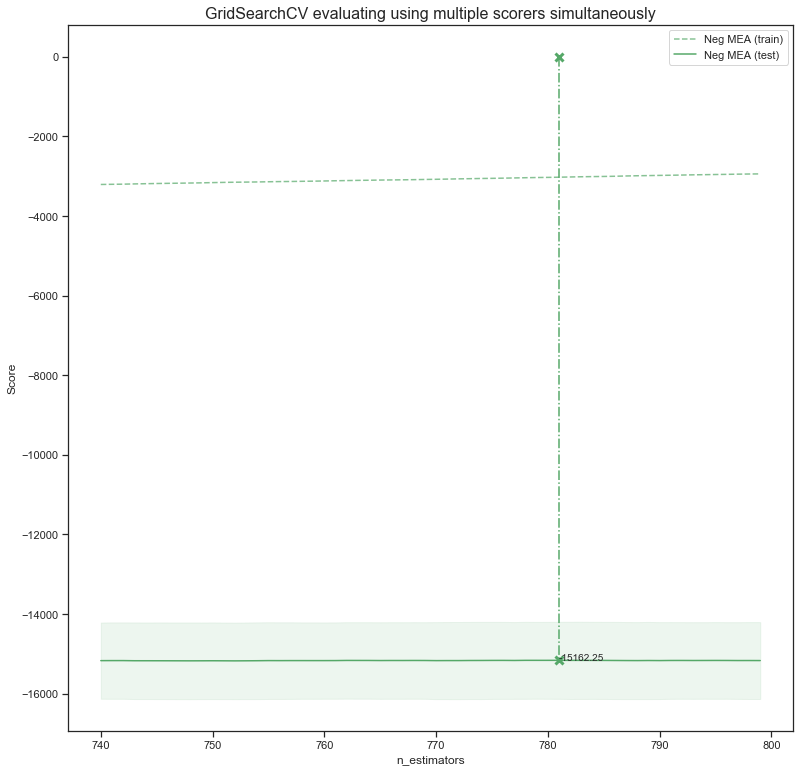

In [76]:
scoring = {'Neg MEA': 'neg_mean_absolute_error', 'R2': 'r2'}

results = clf.cv_results_

plt.figure(figsize=(13, 13))
plt.title("GridSearchCV evaluating using multiple scorers simultaneously",
          fontsize=16)

plt.xlabel("n_estimators")
plt.ylabel("Score")
plt.grid()

ax = plt.axes()
#ax.set_xlim(0, 402)
#ax.set_ylim(0.73, 1)

# Get the regular numpy array from the MaskedArray
X_axis = np.array(results['param_clf__n_estimators'].data, dtype=float)

for scorer, color in zip(['Neg MEA'], ['g']):
    for sample, style in (('train', '--'), ('test', '-')):
        sample_score_mean = results['mean_%s_%s' % (sample, scoring[scorer])]
        sample_score_std = results['std_%s_%s' % (sample, scoring[scorer])]
        ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                        sample_score_mean + sample_score_std,
                        alpha=0.1 if sample == 'test' else 0, color=color)
        ax.plot(X_axis, sample_score_mean, style, color=color,
                alpha=1 if sample == 'test' else 0.7,
                label="%s (%s)" % (scorer, sample))

    best_index = np.nonzero(results['rank_test_%s' % scoring[scorer]] == 1)[0][0]
    best_score = results['mean_test_%s' % scoring[scorer]][best_index]

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot([X_axis[best_index], ] * 2, [0, best_score],
            linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score,
                (X_axis[best_index], best_score + 0.005))

plt.legend(loc="best")
plt.grid('off')
plt.show()

In [24]:
data.iloc[1:3 , 52:68]

,MiscVal,MoSold,YrSold,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_NA,Alley_Pave,LandContour_Bnk,LandContour_HLS,LandContour_Low
1,0,5,2007,0,0,0,1,0,0,1,0,1,0,0,0,0
2,0,9,2008,0,0,0,1,0,0,1,0,1,0,0,0,0
